### PROGETTO - Business Intelligence per i Servizi Finanziari

In [1]:
# importazione delle librerie necessarie
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import statsmodels.api as sm
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
import scipy.optimize as sco
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.signal import savgol_filter
from matplotlib import style

#### Sommario dei dati utilizzati

In [2]:
# download 6 titoli da S&P500 (2 per settore)
# 1. Tecnologia: AAPL, MSFT
# 2. Energia: XOM, CVX
# 3. Bancario: JPM, BAC
start_date = '2012-11-30'
end_date = '2022-11-30'
tickers = ["AAPL", "MSFT", "XOM", "CVX", "JPM", "BAC"]
data = yf.download(tickers, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  6 of 6 completed


Adj Close                                                        \
                 AAPL       BAC        CVX        JPM       MSFT        XOM   
Date                                                                          
2012-11-30  17.924002  8.250028  68.607513  30.657244  21.847515  56.776810   
2012-12-03  17.951868  8.199826  67.938911  30.455751  21.691578  56.435375   
2012-12-04  17.635220  8.291860  67.484505  30.276628  21.642338  56.164829   
2012-12-05  16.500259  8.760899  68.269966  30.746799  21.888548  56.512695   
2012-12-06  16.759043  8.760899  69.100861  30.948296  21.937790  56.686638   

                Close                                ...        Open  \
                 AAPL    BAC         CVX        JPM  ...         CVX   
Date                                                 ...               
2012-11-30  20.902857   9.86  105.690002  41.080002  ...  106.099998   
2012-12-03  20.935356   9.80  104.660004  40.810001  ...  106.000000   
2012-12-04  20.566071   9.91  103.959999  40.570000  ...  104.400002   
2012-12-05  19.242500  10.46  105.169998  41.200001  ...  104.379997   
2012-12-06  19.544287  10.46  106.449997  41.470001  ...  105.489998   

                                                 Volume                      \
                  JPM       MSFT        XOM        AAPL        BAC      CVX   
Date                                                                          
2012-11-30  40.990002  27.049999  88.070000   391319600  108739700  6676400   
2012-12-03  41.270000  26.780001  88.550003   364280000   99872800  5736400   
2012-12-04  40.779999  26.500000  87.379997   557068400  144124500  6665100   
2012-12-05  40.689999  26.379999  87.269997  1044638000  463491000  6430800   
2012-12-06  41.250000  26.809999  87.760002  1177212400  176607900  7392300   

                                          
                 JPM      MSFT       XOM  
Date                                      
2012-11-30  20066600  83690200  15522100  
2012-12-03  18955500  53173800  10937300  
2012-12-04  24031100  49777500  11980000  
2012-12-05  25515600  68283800  12717800  
2012-12-06  20541700  39182300  12077000  

[5 rows x 36 columns]

In [3]:
# informazioni sul dataset
data.describe()

Adj Close                                                      \
              AAPL          BAC          CVX          JPM         MSFT   
count  2517.000000  2517.000000  2517.000000  2517.000000  2517.000000   
mean     59.415931    22.458311    90.484898    82.557510   114.856886   
std      48.729368     9.598369    23.211794    35.336560    90.063149   
min      12.029552     8.199826    46.736897    30.276628    21.642338   
25%      24.394888    13.614970    76.754265    48.659615    40.893833   
50%      38.136883    21.868933    84.233398    82.903687    78.592674   
75%      79.543800    27.781992    98.252983   103.633781   181.190308   
max     180.434296    47.565865   183.177567   164.015762   338.335938   

                          Close                                         ...  \
               XOM         AAPL          BAC          CVX          JPM  ...   
count  2517.000000  2517.000000  2517.000000  2517.000000  2517.000000  ...   
mean     60.131101    61.391537    24.774009   113.356412    93.851482  ...   
std      12.276050    48.346466     9.475852    19.895286    33.885248  ...   
min      26.335978    13.947500     9.800000    54.220001    40.570000  ...   
25%      56.665005    26.705000    16.040001   102.320000    60.959999  ...   
50%      60.021824    40.314999    24.240000   114.180000    93.760002  ...   
75%      63.538376    81.279999    30.879999   121.910004   115.180000  ...   
max     112.333344   182.009995    49.380001   188.050003   171.779999  ...   

              Open                                               Volume  \
               CVX          JPM         MSFT          XOM          AAPL   
count  2517.000000  2517.000000  2517.000000  2517.000000  2.517000e+03   
mean    113.345848    93.851136   119.911752    78.446643  1.756879e+08   
std      19.845245    33.907864    89.532278    16.317048  1.325155e+08   
min      55.259998    40.689999    26.379999    31.410000  3.519590e+07   
25%     102.379997    60.970001    46.750000    71.769997  9.293600e+07   
50%     114.370003    93.820000    84.110001    82.089996  1.315164e+08   
75%     121.870003   115.279999   185.940002    88.910004  2.089388e+08   
max     187.119995   172.710007   344.619995   113.879997  1.460852e+09   

                                                                             
                BAC           CVX           JPM          MSFT           XOM  
count  2.517000e+03  2.517000e+03  2.517000e+03  2.517000e+03  2.517000e+03  
mean   7.728412e+07  8.122344e+06  1.577044e+07  3.241802e+07  1.648936e+07  
std    4.224534e+07  4.311982e+06  6.844212e+06  1.689648e+07  9.376462e+06  
min    1.380540e+07  1.587800e+06  3.220500e+06  7.425600e+06  3.851300e+06  
25%    4.917810e+07  5.403600e+06  1.125030e+07  2.246090e+07  1.019740e+07  
50%    6.618820e+07  6.975500e+06  1.401420e+07  2.843710e+07  1.355150e+07  
75%    9.298740e+07  9.664600e+06  1.846510e+07  3.694380e+07  1.962620e+07  
max    4.634910e+08  5.723100e+07  6.088080e+07  2.484285e+08  8.443940e+07  

[8 rows x 36 columns]

In [4]:
# controllo se ci sono valori nulli
data.isnull().sum()

Adj Close  AAPL    0
           BAC     0
           CVX     0
           JPM     0
           MSFT    0
           XOM     0
Close      AAPL    0
           BAC     0
           CVX     0
           JPM     0
           MSFT    0
           XOM     0
High       AAPL    0
           BAC     0
           CVX     0
           JPM     0
           MSFT    0
           XOM     0
Low        AAPL    0
           BAC     0
           CVX     0
           JPM     0
           MSFT    0
           XOM     0
Open       AAPL    0
           BAC     0
           CVX     0
           JPM     0
           MSFT    0
           XOM     0
Volume     AAPL    0
           BAC     0
           CVX     0
           JPM     0
           MSFT    0
           XOM     0
dtype: int64

In [5]:
# df con solo i prezzi di chiusura
adj_close = data['Adj Close']
adj_close.head()

AAPL       BAC        CVX        JPM       MSFT        XOM
Date                                                                       
2012-11-30  17.924002  8.250028  68.607513  30.657244  21.847515  56.776810
2012-12-03  17.951868  8.199826  67.938911  30.455751  21.691578  56.435375
2012-12-04  17.635220  8.291860  67.484505  30.276628  21.642338  56.164829
2012-12-05  16.500259  8.760899  68.269966  30.746799  21.888548  56.512695
2012-12-06  16.759043  8.760899  69.100861  30.948296  21.937790  56.686638

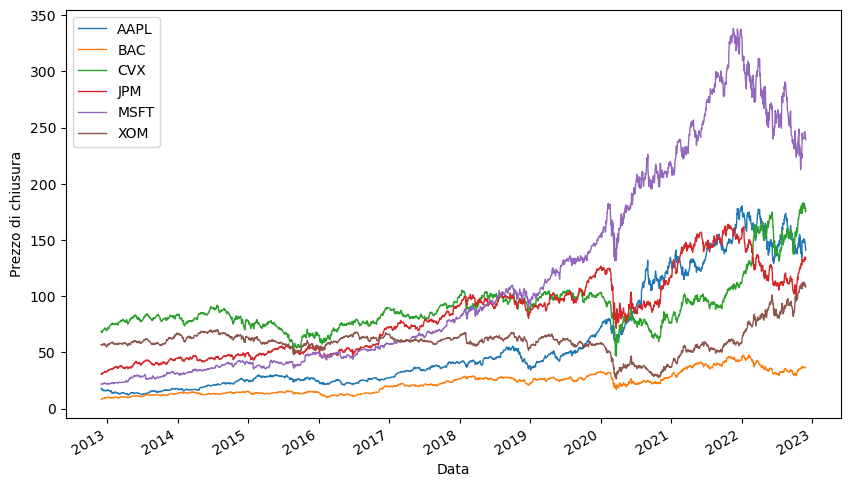

In [6]:
# grafico andamento dei prezzi di chiusura di tutti i titoli
adj_close.plot(figsize=(10, 6), linewidth=1)
plt.legend()
plt.ylabel('Prezzo di chiusura')
plt.xlabel('Data')
plt.show()

#### Statistiche descrittive

In [7]:
# rendimenti semplici
simple_returns = data['Adj Close'].pct_change()
simple_returns_m = simple_returns.groupby(pd.Grouper(freq='M')).mean()
simple_returns.dropna(inplace=True)
simple_returns.head()

AAPL       BAC       CVX       JPM      MSFT       XOM
Date                                                                  
2012-12-03  0.001555 -0.006085 -0.009745 -0.006572 -0.007138 -0.006014
2012-12-04 -0.017639  0.011224 -0.006688 -0.005881 -0.002270 -0.004794
2012-12-05 -0.064358  0.056566  0.011639  0.015529  0.011376  0.006194
2012-12-06  0.015684  0.000000  0.012171  0.006553  0.002250  0.003078
2012-12-07 -0.025565  0.017208  0.005073  0.026284 -0.010101  0.006818

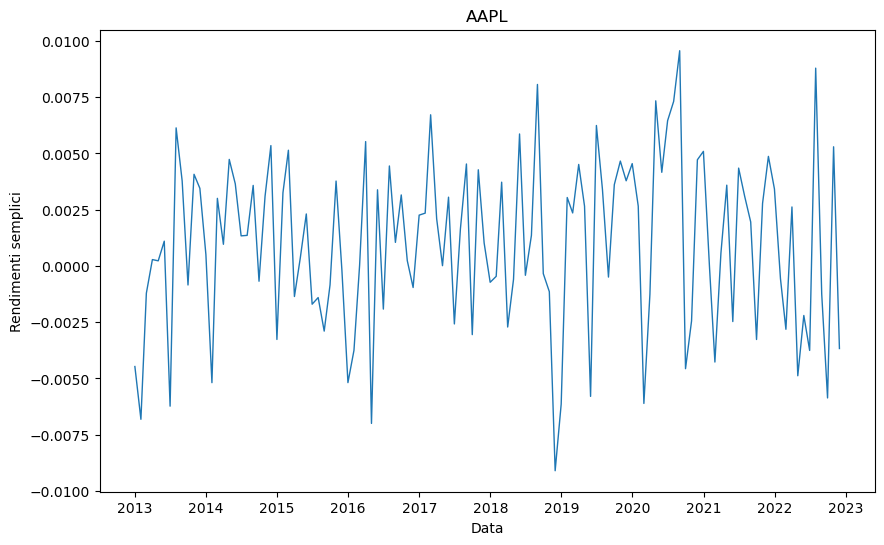

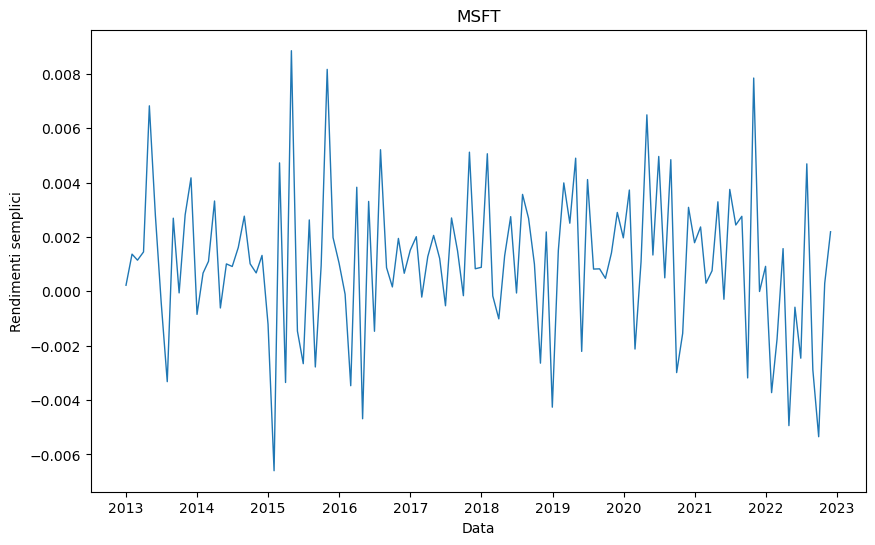

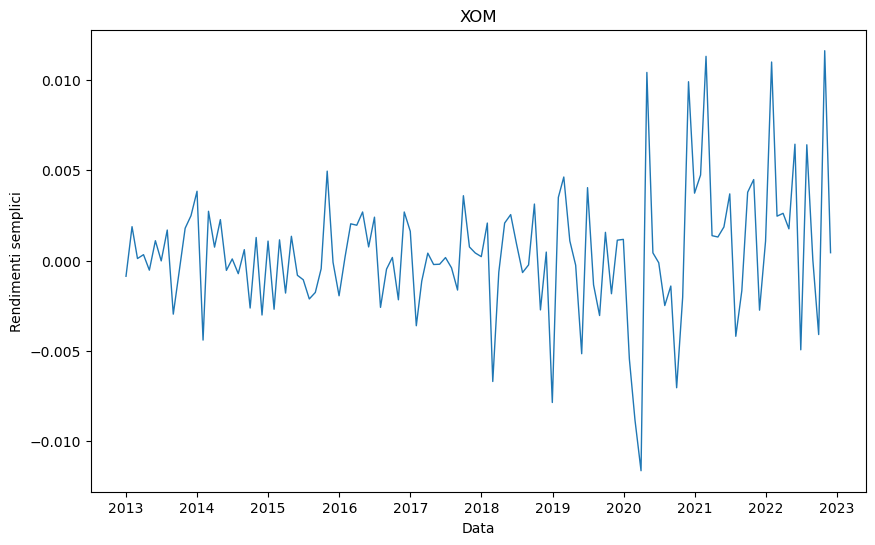

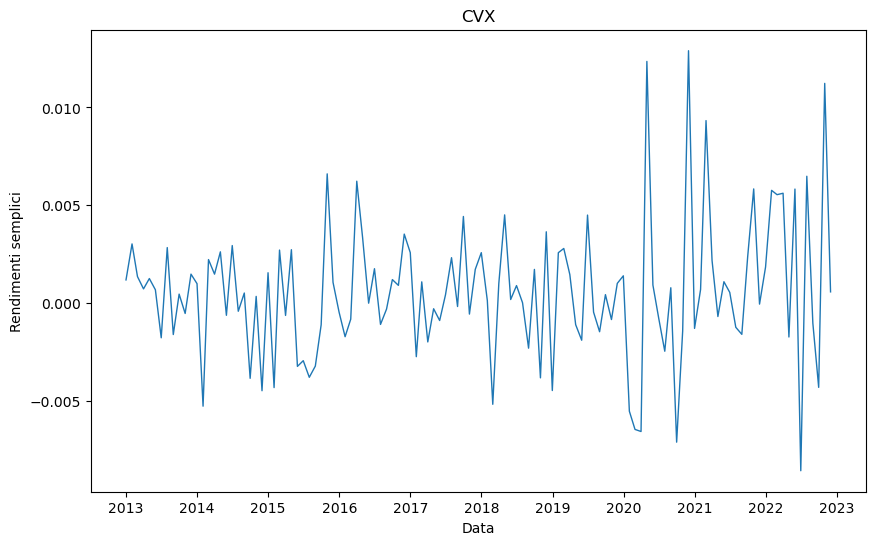

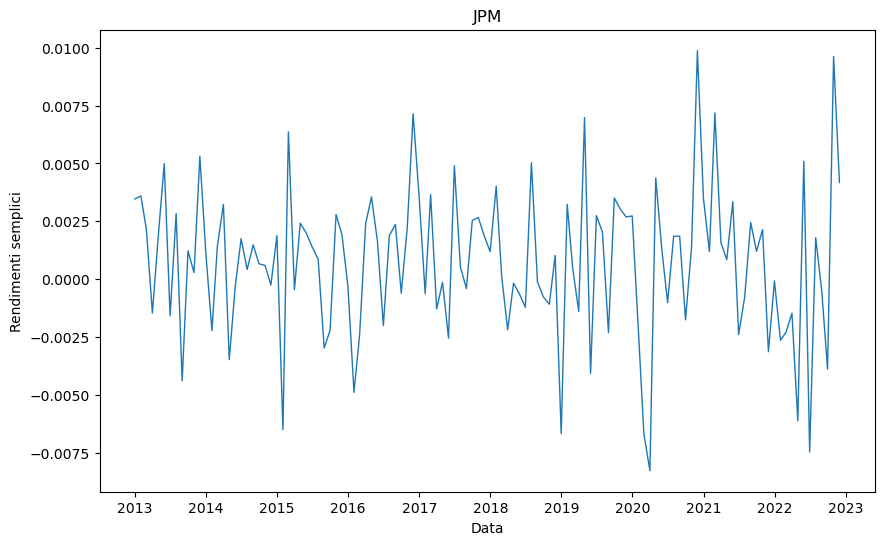

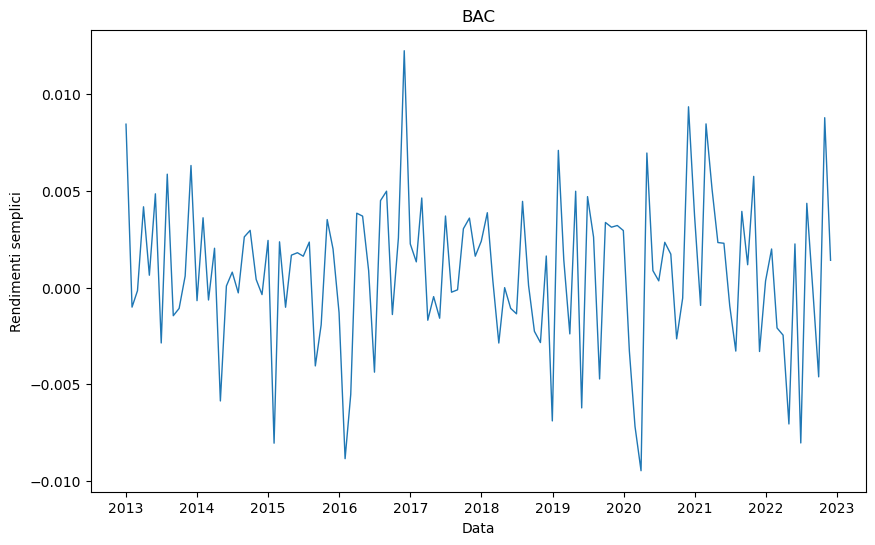

In [8]:
# grafico dei rendimenti semplici
for ticker in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(simple_returns_m[ticker], linewidth=1)
    plt.ylabel('Rendimenti semplici')
    plt.xlabel('Data')
    plt.title(ticker)
    plt.show()

In [9]:
# rendimenti logaritmici
log_returns = np.log(adj_close / adj_close.shift(1))
log_returns_m = log_returns.groupby(pd.Grouper(freq='M')).mean()
log_returns.dropna(inplace=True)
log_returns.head()

AAPL       BAC       CVX       JPM      MSFT       XOM
Date                                                                  
2012-12-03  0.001553 -0.006104 -0.009793 -0.006594 -0.007163 -0.006032
2012-12-04 -0.017796  0.011161 -0.006711 -0.005899 -0.002273 -0.004805
2012-12-05 -0.066522  0.055024  0.011572  0.015410  0.011312  0.006175
2012-12-06  0.015562  0.000000  0.012097  0.006532  0.002247  0.003073
2012-12-07 -0.025897  0.017062  0.005060  0.025945 -0.010152  0.006794

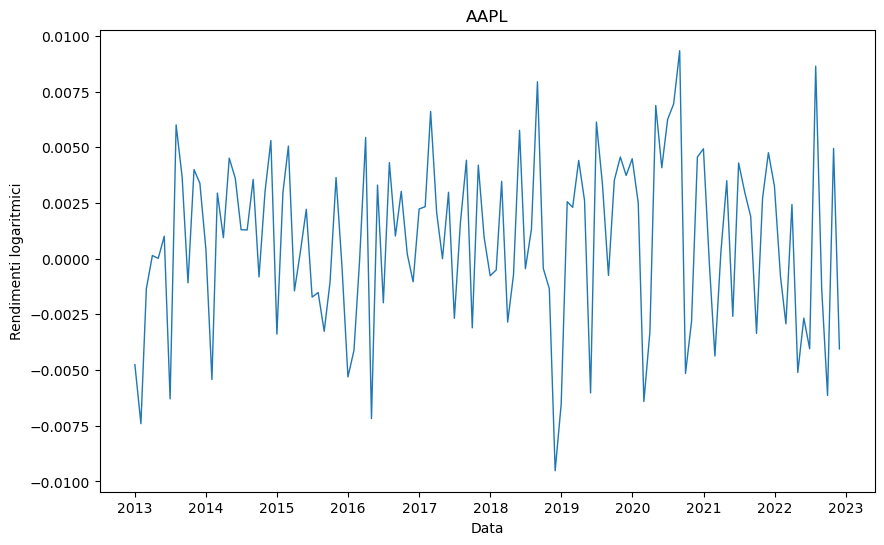

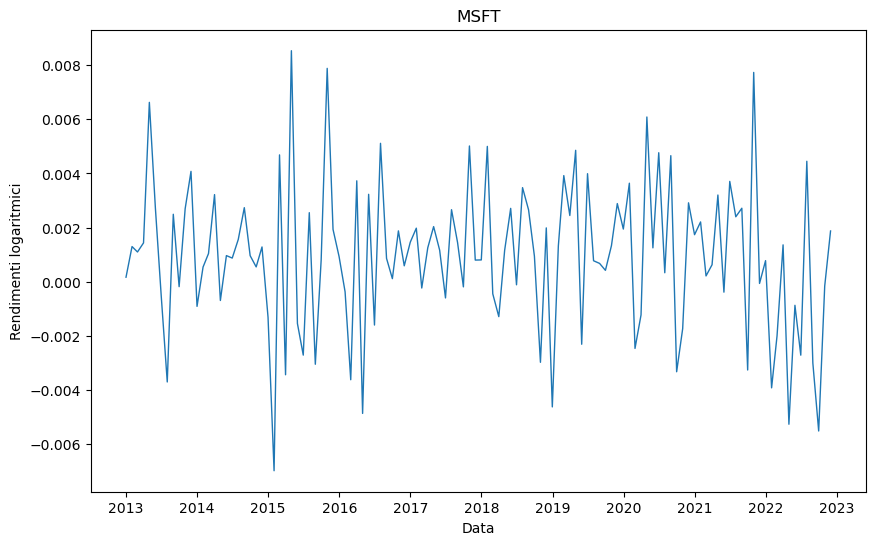

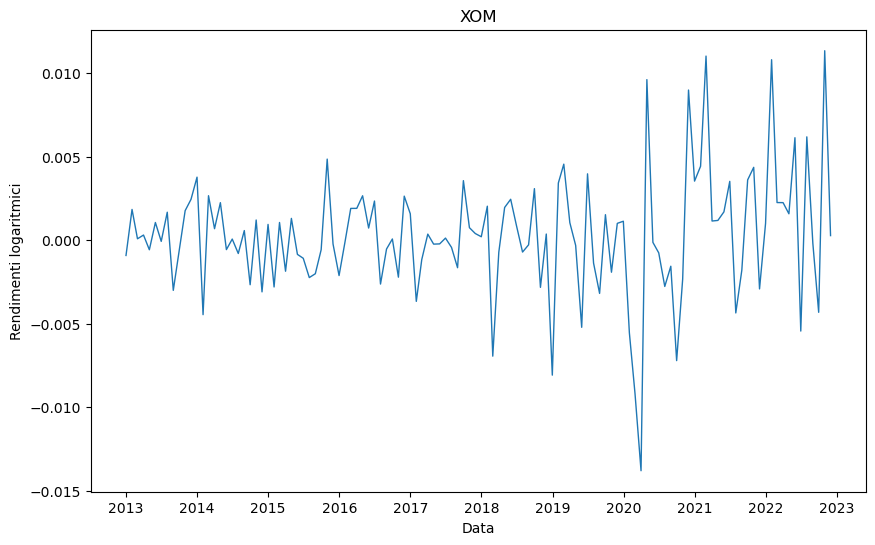

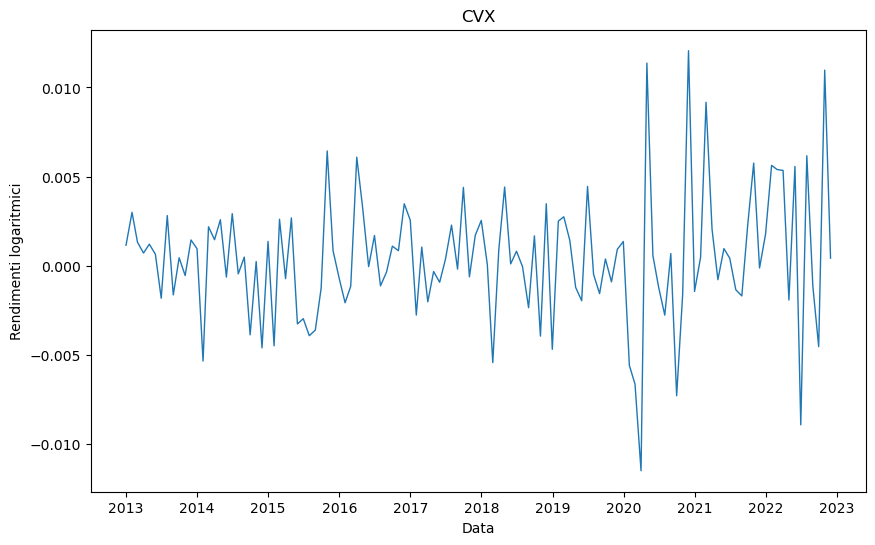

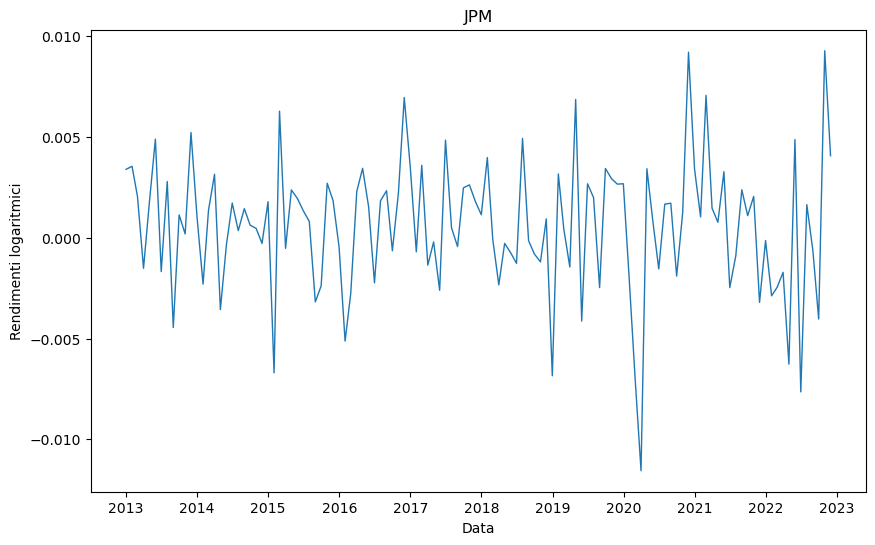

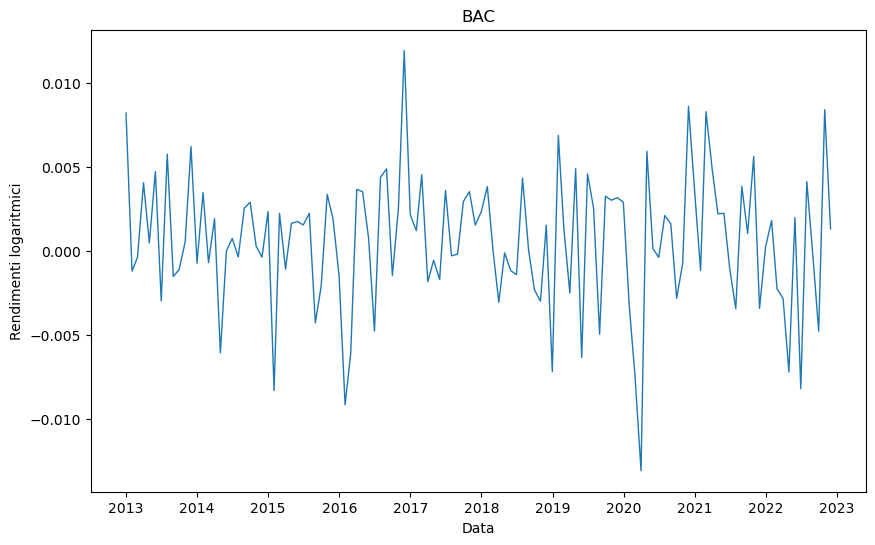

In [10]:
# grafico dei rendimenti logaritmici
for ticker in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(log_returns_m[ticker], linewidth=1)
    plt.ylabel('Rendimenti logaritmici')
    plt.xlabel('Data')
    plt.title(ticker)
    plt.show()

In [11]:
# aggregazione annuale dei prezzi di chiusura
adj_close_y = adj_close.groupby(pd.Grouper(freq='Y')).mean()

In [12]:
# rendimenti cumulati annuali
adj_cum_rtn_y = np.cumprod(1 + simple_returns)
adj_cum_rtn_y.dropna(inplace=True)
adj_cum_rtn_y

AAPL       BAC       CVX       JPM       MSFT       XOM
Date                                                                   
2012-12-03  1.001555  0.993915  0.990255  0.993428   0.992862  0.993986
2012-12-04  0.983889  1.005071  0.983631  0.987585   0.990609  0.989221
2012-12-05  0.920568  1.061924  0.995080  1.002921   1.001878  0.995348
2012-12-06  0.935006  1.061924  1.007191  1.009494   1.004132  0.998412
2012-12-07  0.911103  1.080197  1.012300  1.036027   0.993989  1.005219
...              ...       ...       ...       ...        ...       ...
2022-11-22  8.354379  4.453167  2.659683  4.338485  11.163039  1.978507
2022-11-23  8.403891  4.467420  2.636075  4.384748  11.279212  1.968631
2022-11-25  8.239228  4.478111  2.628348  4.393102  11.275111  1.961699
2022-11-28  8.022831  4.378333  2.551945  4.316317  11.014065  1.902784
2022-11-29  7.853162  4.394963  2.590147  4.387319  10.948917  1.915434

[2516 rows x 6 columns]

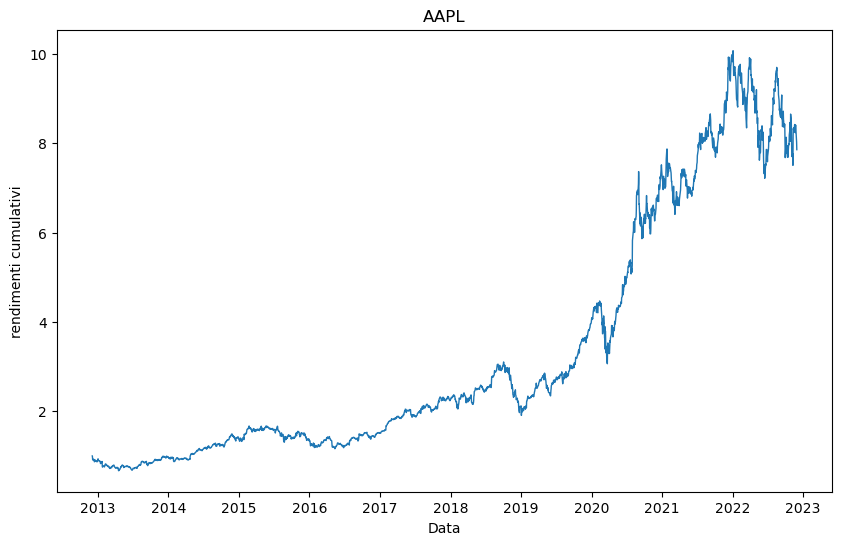

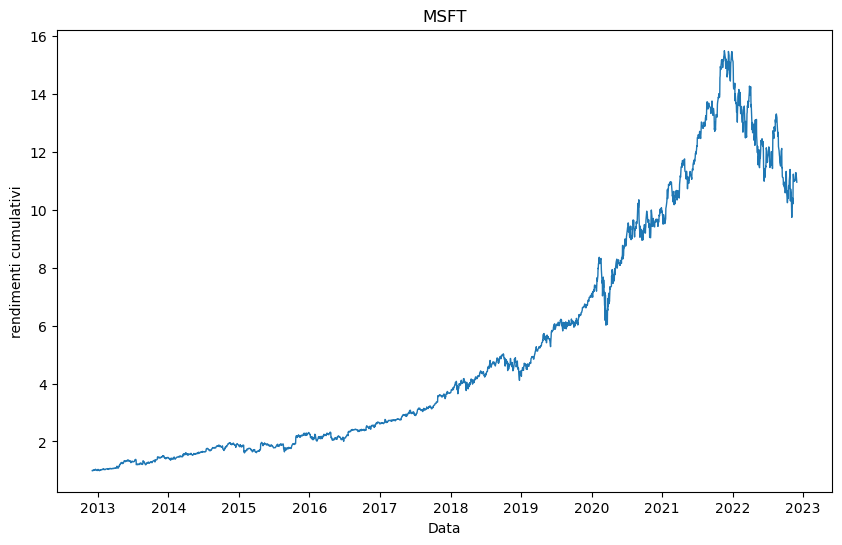

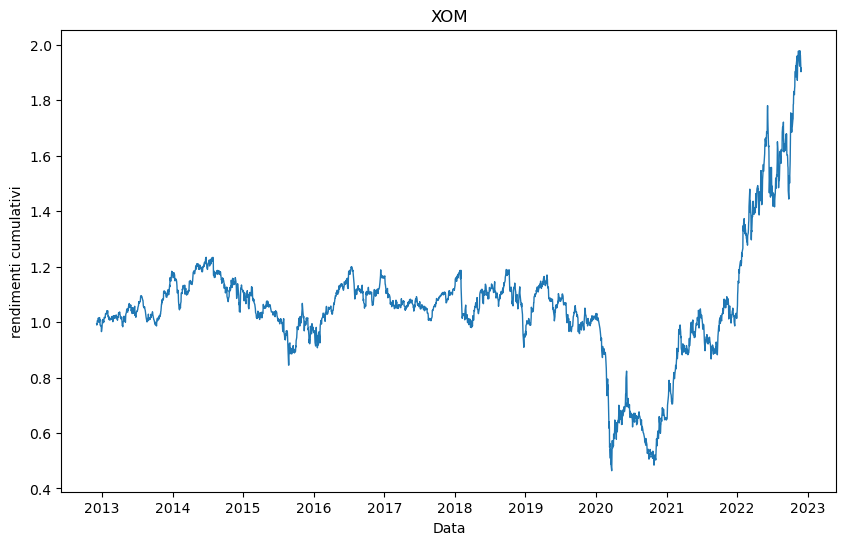

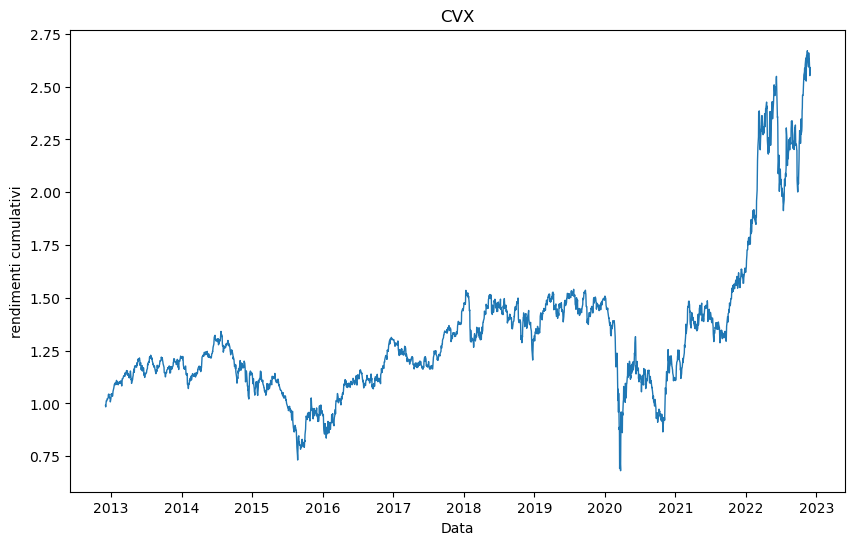

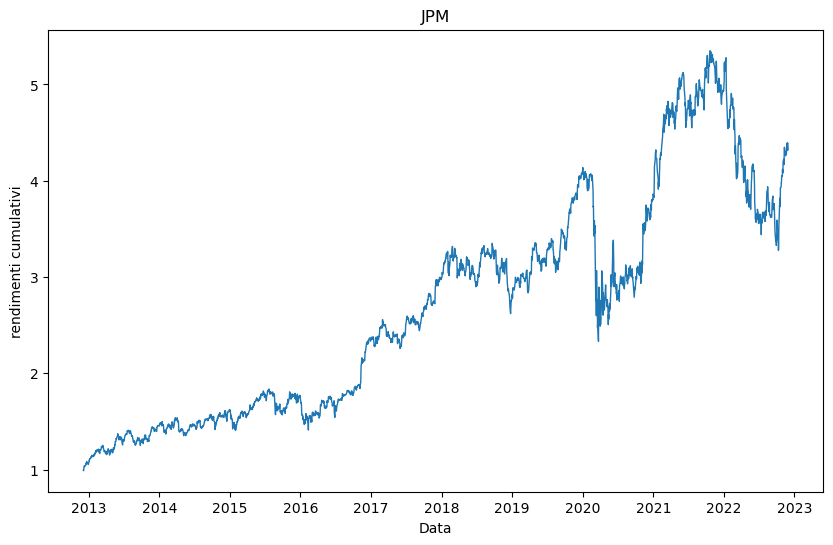

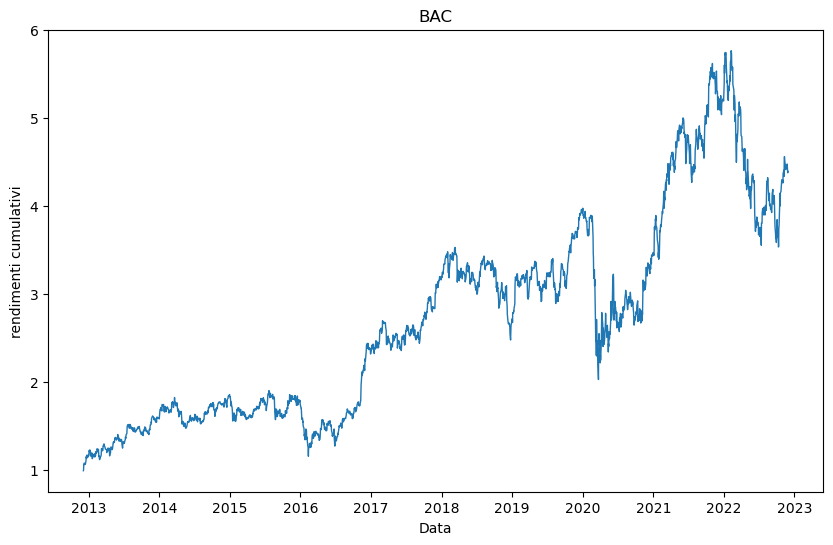

In [13]:
# grafico rendimenti cumulati annuali
for ticker in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(adj_cum_rtn_y[ticker], linewidth=1)
    plt.ylabel('rendimenti cumulativi')
    plt.xlabel('Data')
    plt.title(ticker)
    plt.show()

In [14]:
# rendimenti composti annuali
adj_comp_rtn_y = np.log(adj_close_y / adj_close_y.shift(1))
adj_comp_rtn_y.dropna(inplace=True)
adj_comp_rtn_y

AAPL       BAC       CVX       JPM      MSFT       XOM
Date                                                                  
2013-12-31 -0.109673  0.217819  0.126967  0.209438  0.203127  0.043131
2014-12-31  0.336138  0.198597  0.036009  0.141408  0.295995  0.099430
2015-12-31  0.280119  0.024875 -0.185985  0.119430  0.121916 -0.130664
2016-12-31 -0.117122 -0.057347  0.083934  0.056418  0.195143  0.075796
2017-12-31  0.382806  0.486005  0.149288  0.362562  0.289286 -0.016428
2018-12-31  0.242850  0.199202  0.113402  0.206585  0.358036  0.015353
2019-12-31  0.112397  0.016772  0.034251  0.056811  0.271191 -0.037874
2020-12-31  0.616432 -0.092561 -0.258849 -0.034339  0.404478 -0.447744
2021-12-31  0.397814  0.452860  0.223107  0.410005  0.366999  0.340823
2022-12-31  0.109145 -0.053890  0.453817 -0.172984 -0.010289  0.488810

In [15]:
# info sui rendimenti logaritmici
log_returns.describe()

AAPL          BAC          CVX          JPM         MSFT  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean      0.000819     0.000588     0.000378     0.000588     0.000951   
std       0.018371     0.019385     0.018264     0.016870     0.016973   
min      -0.137708    -0.167204    -0.250062    -0.162106    -0.159453   
25%      -0.007498    -0.008542    -0.007341    -0.007260    -0.006575   
50%       0.000870     0.000567     0.000569     0.000446     0.000830   
75%       0.010331     0.010405     0.008236     0.008656     0.009432   
max       0.113158     0.163786     0.204904     0.165620     0.132929   

               XOM  
count  2516.000000  
mean      0.000258  
std       0.016835  
min      -0.130391  
25%      -0.007303  
50%       0.000117  
75%       0.007897  
max       0.119442

In [16]:
# info sui rendimenti semplici
simple_returns.describe()

AAPL          BAC          CVX          JPM         MSFT  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean      0.000988     0.000777     0.000544     0.000730     0.001096   
std       0.018339     0.019410     0.018158     0.016893     0.016963   
min      -0.128647    -0.153973    -0.221248    -0.149649    -0.147390   
25%      -0.007470    -0.008506    -0.007314    -0.007234    -0.006553   
50%       0.000870     0.000567     0.000569     0.000446     0.000830   
75%       0.010384     0.010459     0.008270     0.008694     0.009477   
max       0.119808     0.177962     0.227407     0.180125     0.142169   

               XOM  
count  2516.000000  
mean      0.000400  
std       0.016830  
min      -0.122248  
25%      -0.007276  
50%       0.000117  
75%       0.007928  
max       0.126868

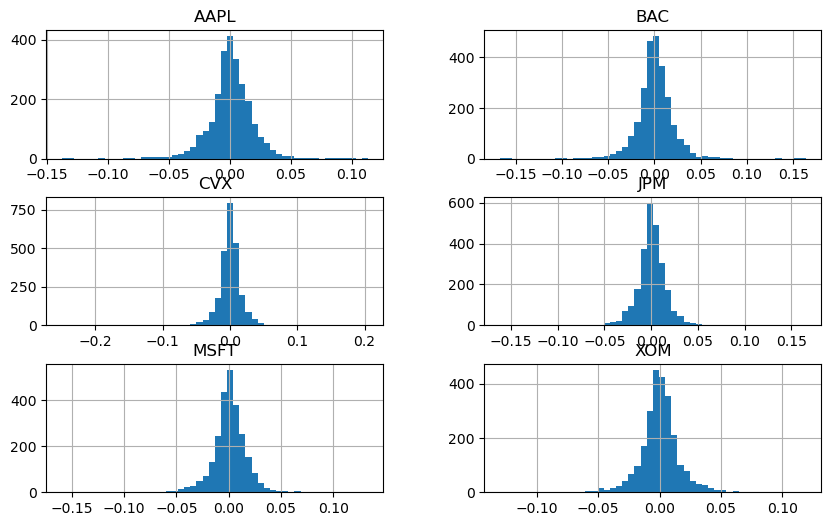

In [17]:
# grafico a istogramma dei rendimenti logaritmici
log_returns.hist(bins=50, figsize=(10, 6))
plt.show()

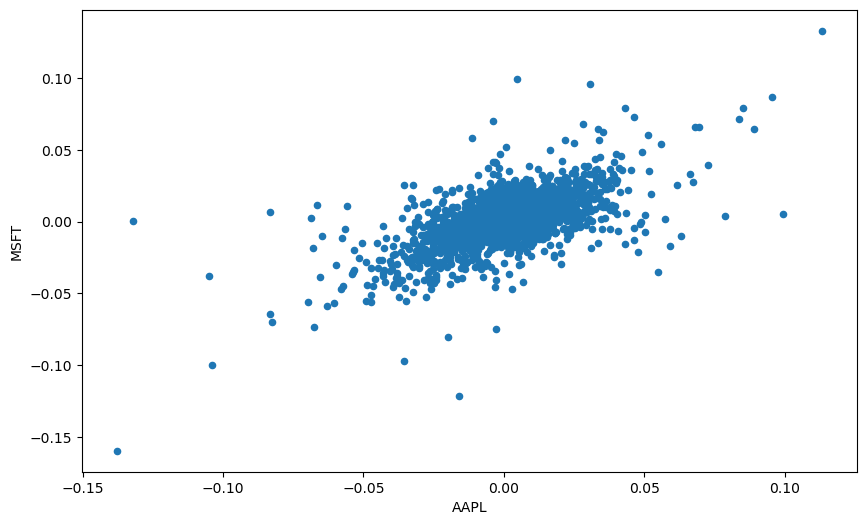

In [18]:
# grafico a dispersione dei rendimenti logaritmici dei titoli tecnologici (AAPL e MSFT)
log_returns.plot(kind='scatter', x='AAPL', y='MSFT', figsize=(10, 6))
plt.show()

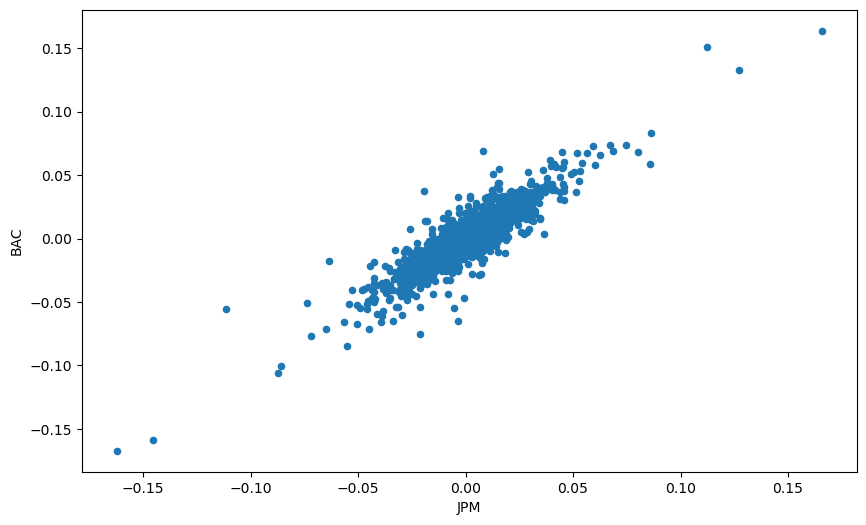

In [19]:
# grafico a dispersione dei rendimenti logaritmici dei titoli bancari (JPM e BAC)
log_returns.plot(kind='scatter', x='JPM', y='BAC', figsize=(10, 6))
plt.show()

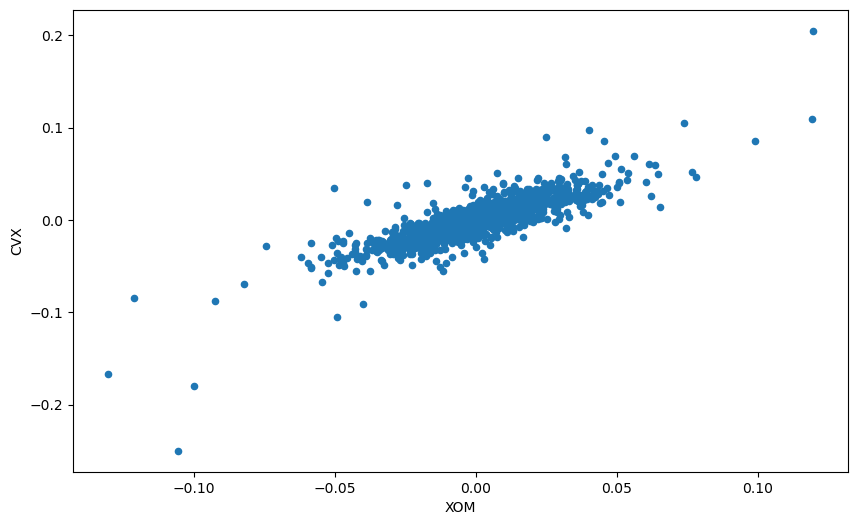

In [20]:
# grafico a dispersione dei rendimenti logaritmici dei titoli energetici (XOM e CVX)
log_returns.plot(kind='scatter', x='XOM', y='CVX', figsize=(10, 6))
plt.show()

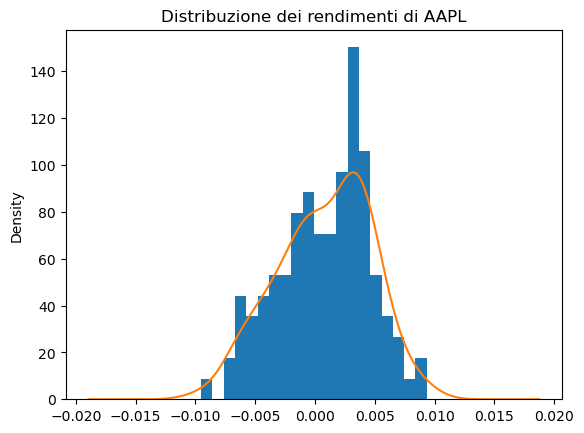

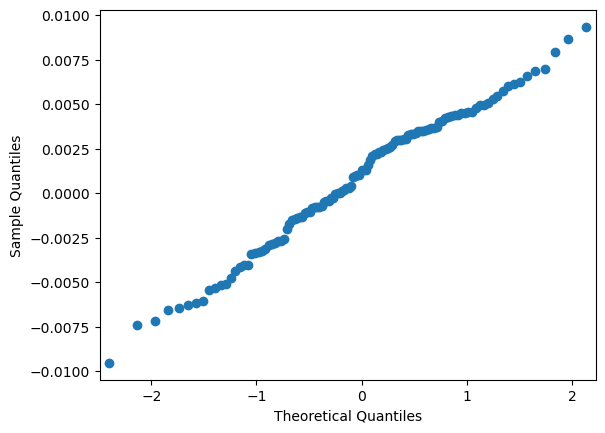

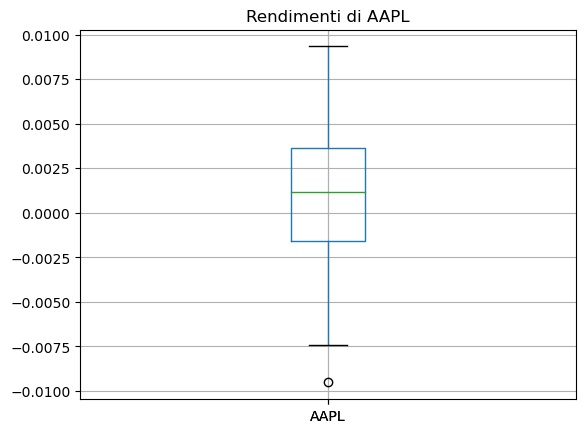

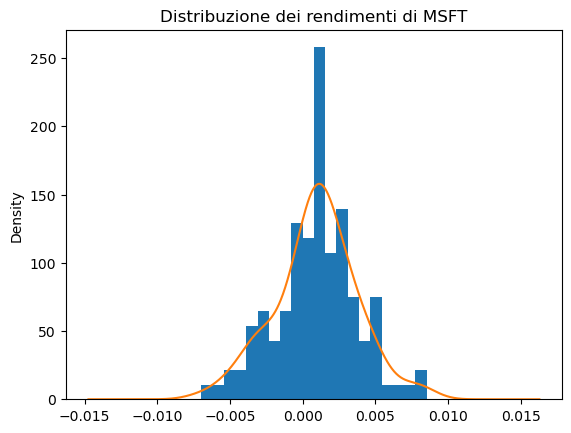

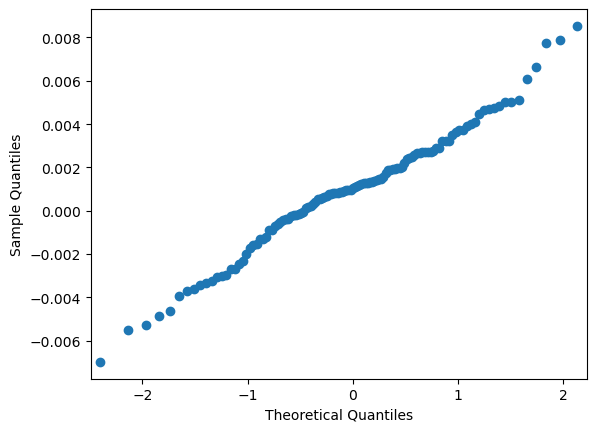

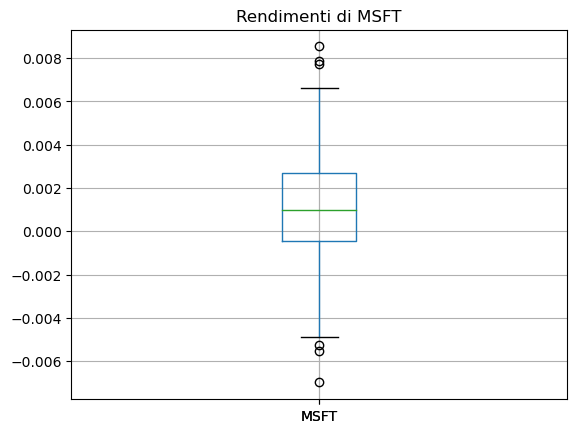

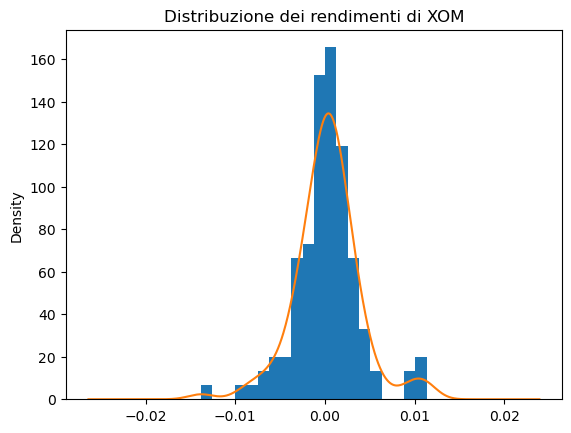

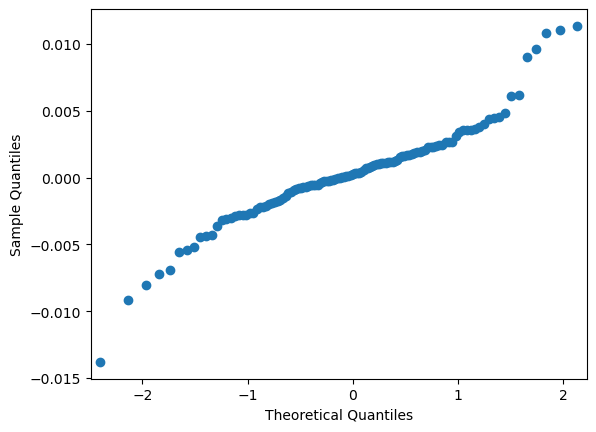

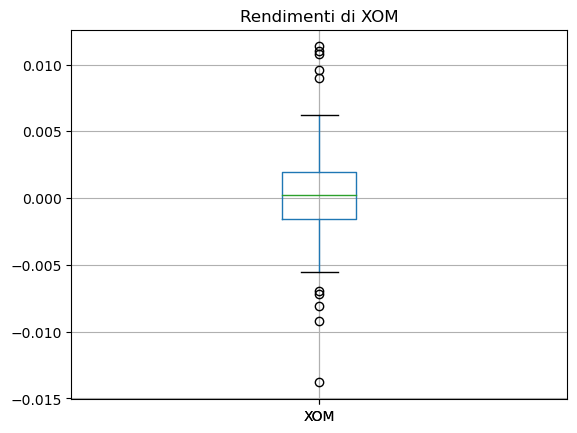

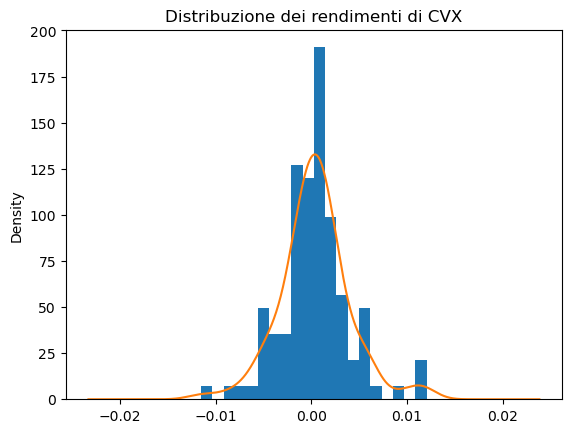

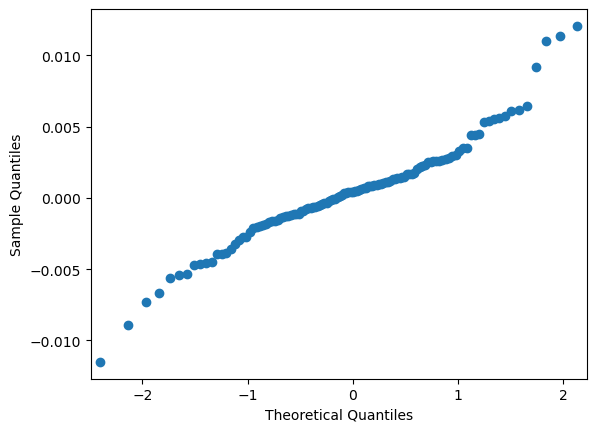

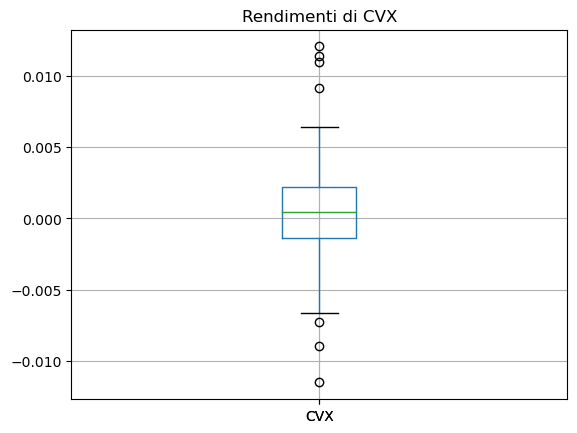

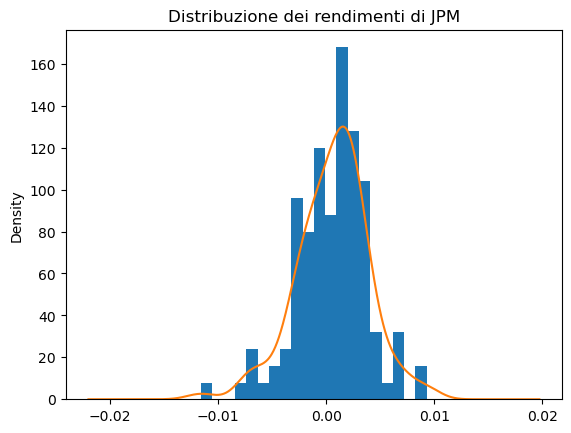

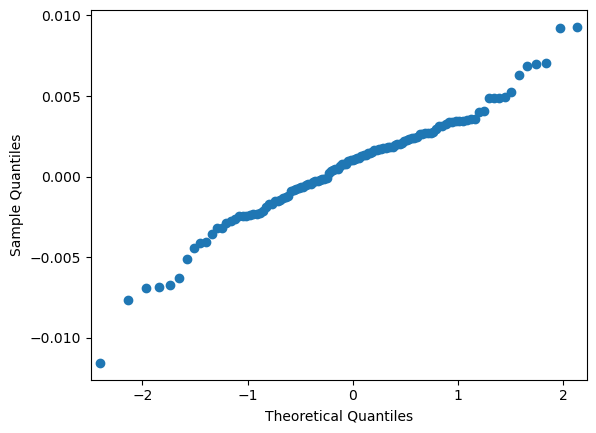

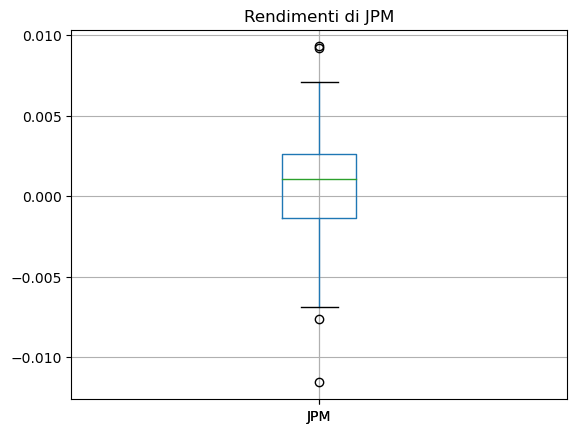

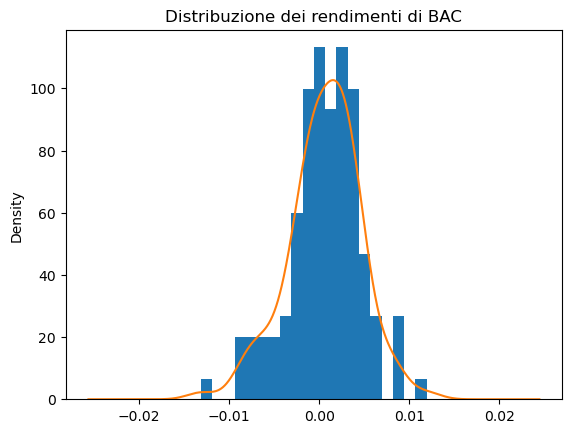

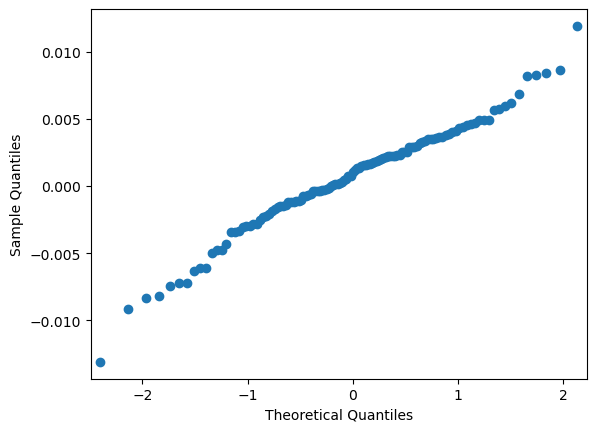

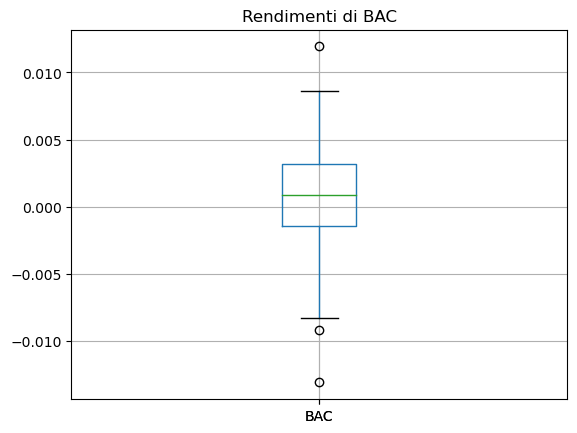

In [21]:
# grafico a densità dei rendimenti logaritmici per ogni titolo
for ticker in tickers:
    plt.figure()
    plt.hist(log_returns_m[ticker], density = True, bins=20)
    plt.title('Distribuzione dei rendimenti di {}'.format(ticker))
    log_returns_m[ticker].plot.density()

    sm.qqplot(log_returns_m[ticker], line = 's')

    plt.figure()
    plt.boxplot(log_returns_m[ticker], sym = 'x')
    plt.title('Rendimenti di {}'.format(ticker))
    log_returns_m[ticker].to_frame().boxplot()

plt.show()

In [22]:
# Calcolare statistiche descrittive univariate (media, varianza, deviazione standard,asimmetria, curtosi) per ogni serie di rendimenti
for ticker in tickers:
    # Media
    print(f"Ticker: {ticker}")
    print("Media:", round(log_returns[ticker].mean(), 4))
    # Varianza
    print("Varianza:", round(log_returns[ticker].var(), 4))
    # Deviazione standard
    print("Deviazione Standard:", round(log_returns[ticker].std(), 4))
    # Asimmetria
    print("Asimmetria:", round(log_returns[ticker].skew(), 4))
    # Curtosi
    print("Curtosi:", round(log_returns[ticker].kurtosis(), 4))
    print()


Ticker: AAPL
Media: 0.0008
Varianza: 0.0003
Deviazione Standard: 0.0184
Asimmetria: -0.3678
Curtosi: 6.0882

Ticker: MSFT
Media: 0.001
Varianza: 0.0003
Deviazione Standard: 0.017
Asimmetria: -0.2927
Curtosi: 9.3039

Ticker: XOM
Media: 0.0003
Varianza: 0.0003
Deviazione Standard: 0.0168
Asimmetria: -0.1723
Curtosi: 7.8798

Ticker: CVX
Media: 0.0004
Varianza: 0.0003
Deviazione Standard: 0.0183
Asimmetria: -1.0027
Curtosi: 29.3853

Ticker: JPM
Media: 0.0006
Varianza: 0.0003
Deviazione Standard: 0.0169
Asimmetria: -0.0678
Curtosi: 13.807

Ticker: BAC
Media: 0.0006
Varianza: 0.0004
Deviazione Standard: 0.0194
Asimmetria: -0.0652
Curtosi: 9.9102



In [23]:
# correlazione tra i rendimenti logaritmici dei titoli tecnologici (AAPL e MSFT)
tech_corr = log_returns['MSFT'].corr(log_returns['AAPL'])
print(tech_corr)

0.6228059257749843


In [24]:
# correlazione tra i rendimenti logaritmici dei titoli bancari (JPM e BAC)
bank_corr = log_returns['JPM'].corr(log_returns['BAC'])
print(bank_corr)

0.8954206622906208


In [25]:
# correlazione tra i rendimenti logaritmici dei titoli energetici (XOM e CVX)
energy_corr = log_returns['XOM'].corr(log_returns['CVX'])
print(energy_corr)

0.8334034241649357


In [26]:
# matrice di covarianza
cov_matrix = log_returns.cov()
cov_matrix

AAPL       BAC       CVX       JPM      MSFT       XOM
AAPL  0.000337  0.000144  0.000112  0.000130  0.000194  0.000097
BAC   0.000144  0.000376  0.000204  0.000293  0.000148  0.000183
CVX   0.000112  0.000204  0.000334  0.000189  0.000120  0.000256
JPM   0.000130  0.000293  0.000189  0.000285  0.000136  0.000165
MSFT  0.000194  0.000148  0.000120  0.000136  0.000288  0.000096
XOM   0.000097  0.000183  0.000256  0.000165  0.000096  0.000283

In [27]:
# matrice di correlazione
corr_matrix = log_returns.corr()
corr_matrix

AAPL       BAC       CVX       JPM      MSFT       XOM
AAPL  1.000000  0.404841  0.334773  0.419122  0.622806  0.313834
BAC   0.404841  1.000000  0.576613  0.895421  0.450774  0.561163
CVX   0.334773  0.576613  1.000000  0.611871  0.385509  0.833403
JPM   0.419122  0.895421  0.611871  1.000000  0.475360  0.580816
MSFT  0.622806  0.450774  0.385509  0.475360  1.000000  0.335442
XOM   0.313834  0.561163  0.833403  0.580816  0.335442  1.000000

In [28]:
# correlazione nel tempo per ogni settore
corr_over_time_tech = log_returns['MSFT'].rolling(window=90).corr(log_returns['AAPL'])
corr_over_time_energy = log_returns['XOM'].rolling(window=90).corr(log_returns['CVX'])
corr_over_time_bank = log_returns['JPM'].rolling(window=90).corr(log_returns['BAC'])

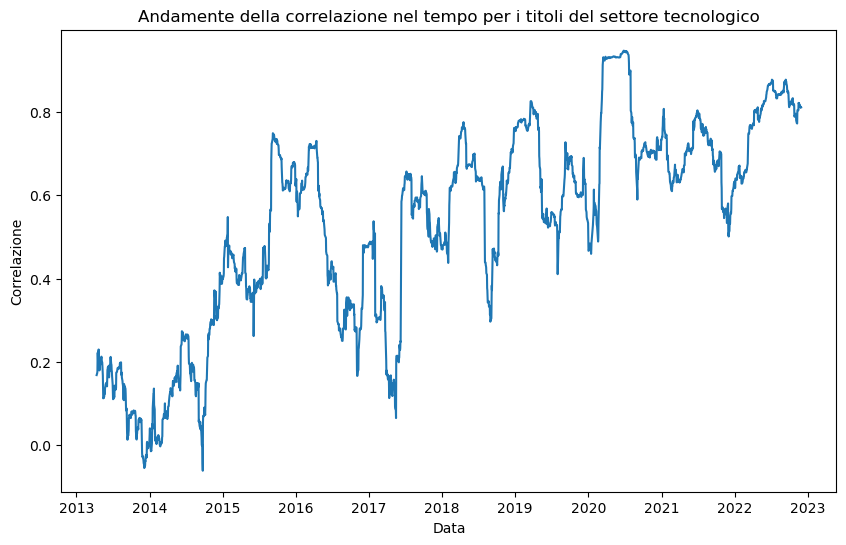

In [29]:
# grafico correlazione nel tempo per il settore tecnologico
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(corr_over_time_tech.index, corr_over_time_tech)
ax.set_xlabel('Data')
ax.set_ylabel('Correlazione')
ax.set_title('Andamente della correlazione nel tempo per i titoli del settore tecnologico')
plt.show()

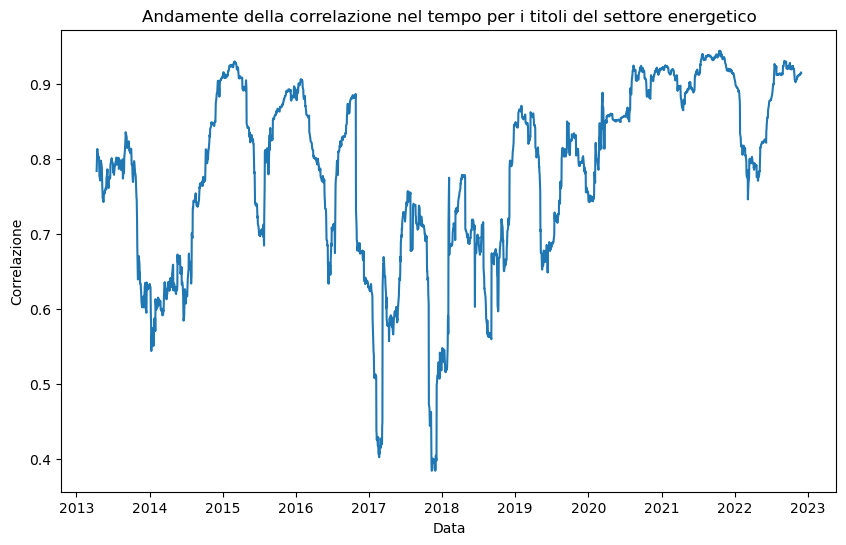

In [30]:
# grafico correlazione nel tempo per il settore energetico
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(corr_over_time_energy.index, corr_over_time_energy)
ax.set_xlabel('Data')
ax.set_ylabel('Correlazione')
ax.set_title('Andamente della correlazione nel tempo per i titoli del settore energetico')
plt.show()

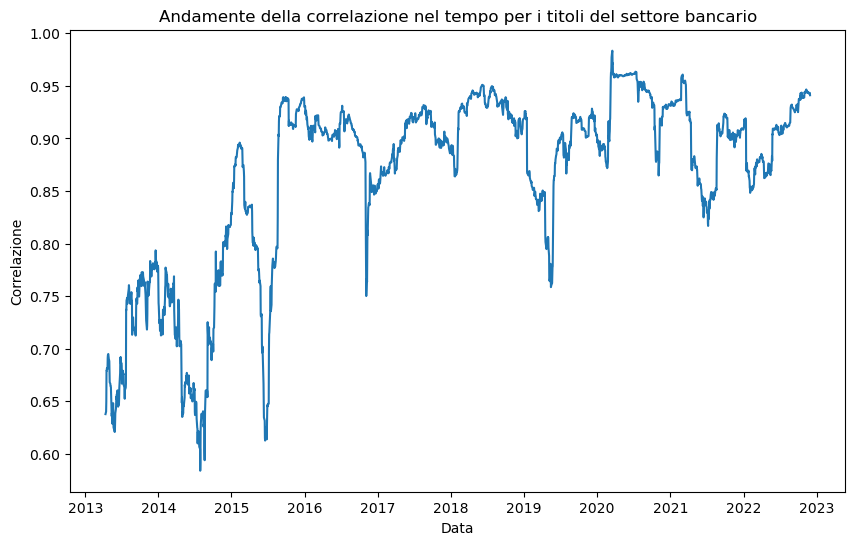

In [31]:
# grafico correlazione nel tempo per il settore bancario
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(corr_over_time_bank.index, corr_over_time_bank)
ax.set_xlabel('Data')
ax.set_ylabel('Correlazione')
ax.set_title('Andamente della correlazione nel tempo per i titoli del settore bancario')
plt.show()

In [32]:
# Calcolo delle correlazioni medie
mean_corr = corr_matrix.mean()

Text(0, 0.5, 'MSFT')

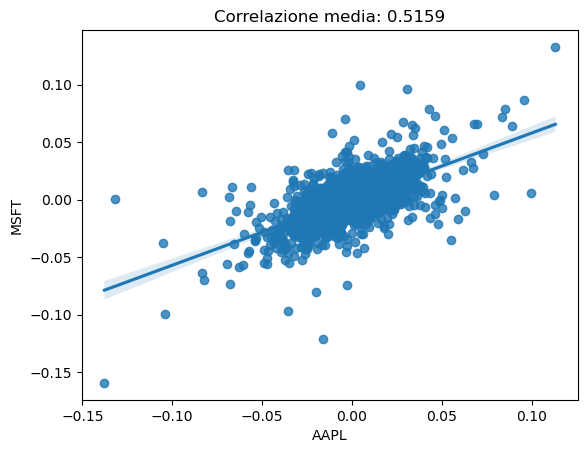

In [33]:
# Grafico di dispersione delle correlazioni medie tra AAPL e MSFT (titoli tecnologici)
plt.figure()
sns.regplot(x=log_returns['AAPL'], y=log_returns['MSFT'], data=log_returns)
plt.title("Correlazione media: " + str(round(mean_corr['AAPL'], 4)))
plt.xlabel('AAPL')
plt.ylabel('MSFT')

Text(0, 0.5, 'CVX')

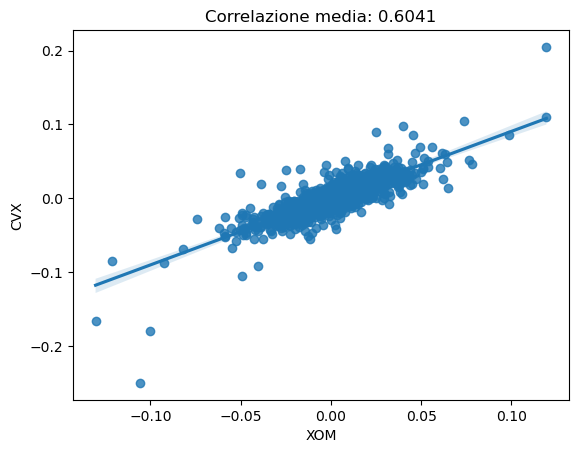

In [34]:
# Grafico di dispersione delle correlazioni medie tra  CVX e XOM (titoli energetici)
plt.figure()
sns.regplot(x=log_returns['XOM'], y=log_returns['CVX'], data=log_returns)
plt.title("Correlazione media: " + str(round(mean_corr['XOM'], 4)))
plt.xlabel('XOM')
plt.ylabel('CVX')

Text(0, 0.5, 'BAC')

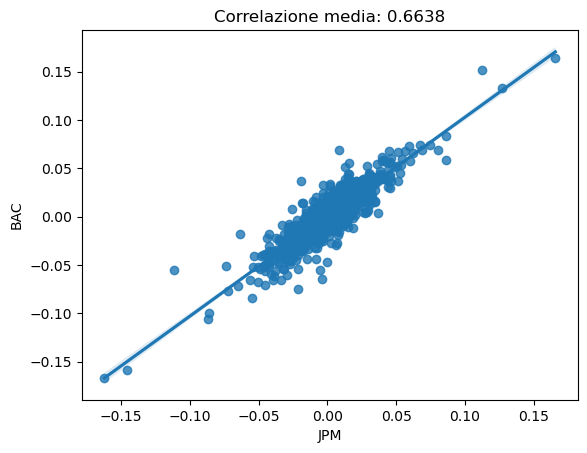

In [35]:
# Grafico di dispersione delle correlazioni medie tra  JPM e BAC (titoli bancari)
plt.figure()
sns.regplot(x=log_returns['JPM'], y=log_returns['BAC'], data=log_returns)
plt.title("Correlazione media: " + str(round(mean_corr['JPM'], 4)))
plt.xlabel('JPM')
plt.ylabel('BAC')

#### Analisi di previsione

In [36]:
future_days = 5
for ticker in tickers:
    position = adj_close.columns.get_loc(ticker) + 1
    adj_close.insert(position, f"{ticker}_5_Days_Price_Forecast", adj_close[ticker].shift(-future_days))

adj_close.head(12)

AAPL  AAPL_5_Days_Price_Forecast       BAC  \
Date                                                          
2012-11-30  17.924002                   16.330605  8.250028   
2012-12-03  17.951868                   16.225563  8.199826   
2012-12-04  17.635220                   16.579885  8.291860   
2012-12-05  16.500259                   16.506701  8.760899   
2012-12-06  16.759043                   16.221582  8.760899   
2012-12-07  16.330605                   15.612150  8.911656   
2012-12-10  16.225563                   15.888996  8.853029   
2012-12-11  16.579885                   16.350510  8.802775   
2012-12-12  16.506701                   16.118063  8.886533   
2012-12-13  16.221582                   15.977806  8.827904   
2012-12-14  15.612150                   15.904310  8.861405   
2012-12-17  15.888996                   15.930039  9.213184   

            BAC_5_Days_Price_Forecast        CVX  CVX_5_Days_Price_Forecast  \
Date                                                                          
2012-11-30                   8.911656  68.607513                  69.451408   
2012-12-03                   8.853029  67.938911                  69.431946   
2012-12-04                   8.802775  67.484505                  69.938225   
2012-12-05                   8.886533  68.269966                  70.158981   
2012-12-06                   8.827904  69.100861                  70.048615   
2012-12-07                   8.861405  69.451408                  69.990181   
2012-12-10                   9.213184  69.431946                  70.548454   
2012-12-11                   9.514702  69.938225                  71.470222   
2012-12-12                   9.372317  70.158981                  71.346893   
2012-12-13                   9.648714  70.048615                  71.651985   
2012-12-14                   9.456073  69.990181                  71.217041   
2012-12-17                   9.422571  70.548454                  70.515976   

                  JPM  JPM_5_Days_Price_Forecast       MSFT  \
Date                                                          
2012-11-30  30.657244                  31.761747  21.847515   
2012-12-03  30.455751                  31.575153  21.691578   
2012-12-04  30.276628                  31.821444  21.642338   
2012-12-05  30.746799                  31.918447  21.888548   
2012-12-06  30.948296                  31.925919  21.937790   
2012-12-07  31.761747                  31.948309  21.716196   
2012-12-10  31.575153                  32.448307  22.110134   
2012-12-11  31.821444                  32.739368  22.422016   
2012-12-12  31.918447                  32.485622  22.356358   
2012-12-13  31.925919                  33.231915  22.249659   
2012-12-14  31.948309                  32.836376  22.003443   
2012-12-17  32.448307                  32.776680  22.241455   

            MSFT_5_Days_Price_Forecast        XOM  XOM_5_Days_Price_Forecast  
Date                                                                          
2012-11-30                   21.716196  56.776810                  57.073101  
2012-12-03                   22.110134  56.435375                  56.950729  
2012-12-04                   22.422016  56.164829                  57.324333  
2012-12-05                   22.356358  56.512695                  57.620655  
2012-12-06                   22.249659  56.686638                  57.060234  
2012-12-07                   22.003443  57.073101                  56.738152  
2012-12-10                   22.241455  56.950729                  57.247032  
2012-12-11                   22.618988  57.324333                  57.691509  
2012-12-12                   22.413807  57.620655                  56.970051  
2012-12-13                   22.717476  57.060234                  57.259922  
2012-12-14                   22.528708  56.738152                  56.190624  
2012-12-17                   22.208626  57.247032                  55.990917

In [37]:
# dividi il dataset in tanti dataset quanti sono i titoli
adj_close_tickers = [adj_close[[ticker, f"{ticker}_5_Days_Price_Forecast"]] for ticker in tickers]
adj_close_tickers

[                  AAPL  AAPL_5_Days_Price_Forecast
 Date                                              
 2012-11-30   17.924002                   16.330605
 2012-12-03   17.951868                   16.225563
 2012-12-04   17.635220                   16.579885
 2012-12-05   16.500259                   16.506701
 2012-12-06   16.759043                   16.221582
 ...                ...                         ...
 2022-11-22  149.743912                         NaN
 2022-11-23  150.631348                         NaN
 2022-11-25  147.679932                         NaN
 2022-11-28  143.801239                         NaN
 2022-11-29  140.760086                         NaN
 
 [2517 rows x 2 columns],
                   MSFT  MSFT_5_Days_Price_Forecast
 Date                                              
 2012-11-30   21.847515                   21.716196
 2012-12-03   21.691578                   22.110134
 2012-12-04   21.642338                   22.422016
 2012-12-05   21.888548             

In [38]:
adj_close_tickers[0].shape

(2517, 2)

[*********************100%***********************]  6 of 6 completed
svm_model confidence score is:  0.6959329425819054
Mean Absolute Error: 3.027130282042499
Mean Squared Error: 17.795922871193586
R2 Score: 0.9840914170685988
0.6959329425819054


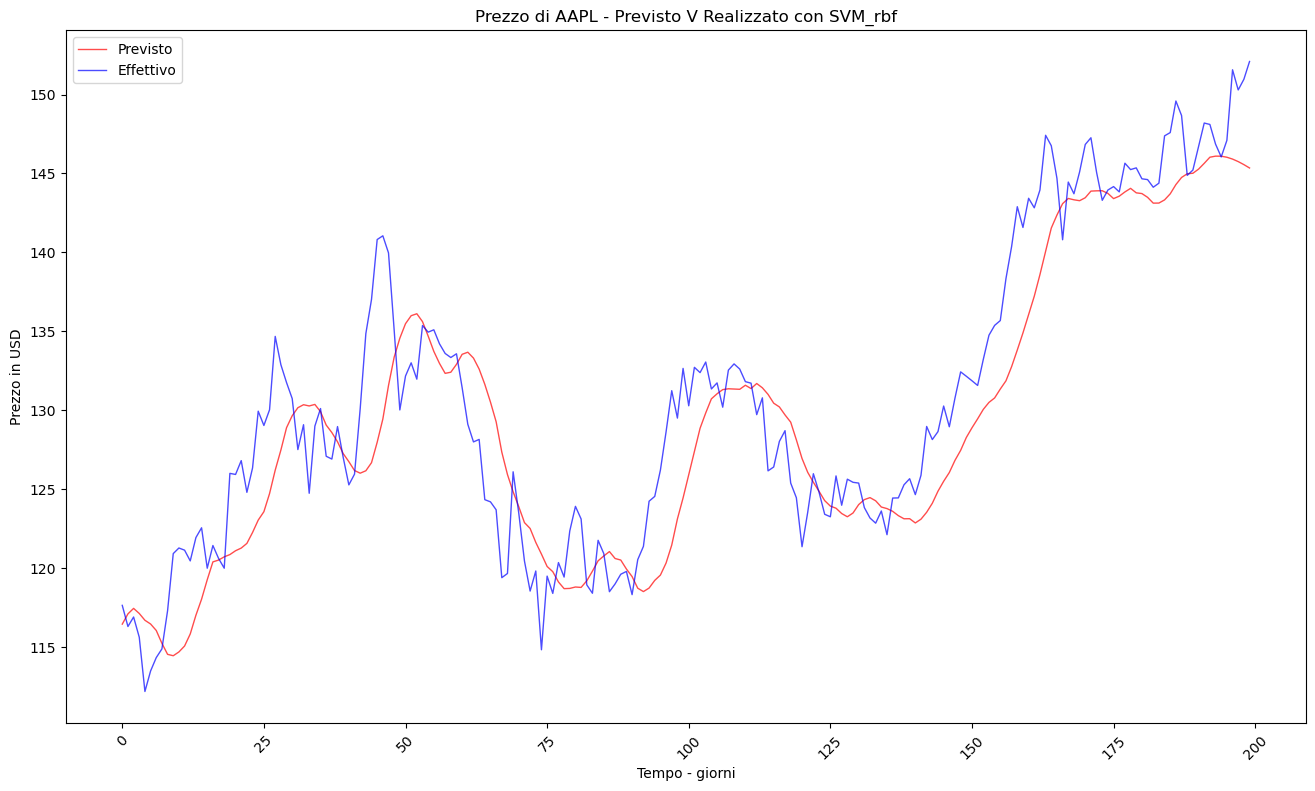

svm_model confidence score is:  0.8606004208003003
Mean Absolute Error: 4.986586265638536
Mean Squared Error: 44.857155478661056
R2 Score: 0.9811985450508284
0.8606004208003003


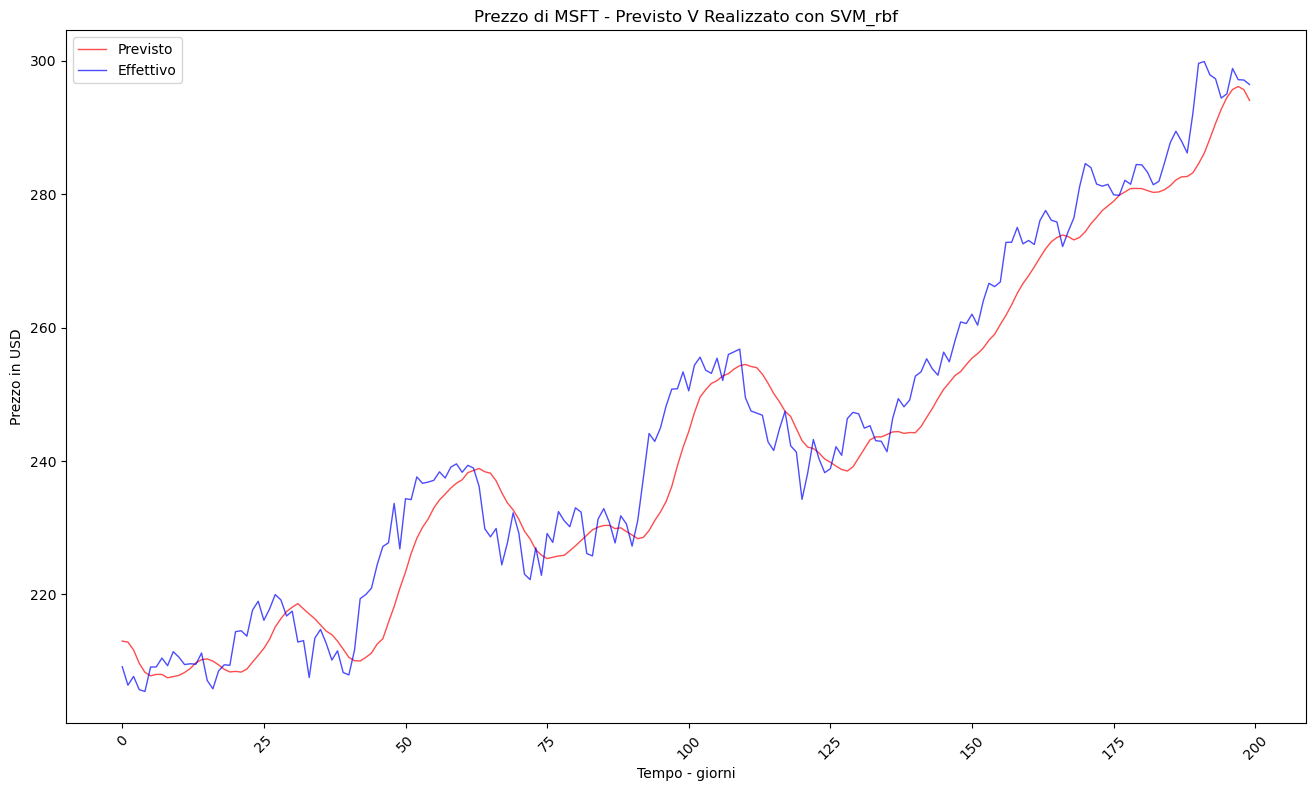

svm_model confidence score is:  0.9346760640164917
Mean Absolute Error: 1.8373926668901845
Mean Squared Error: 6.000578872426714
R2 Score: 0.9465962450608918
0.9346760640164917


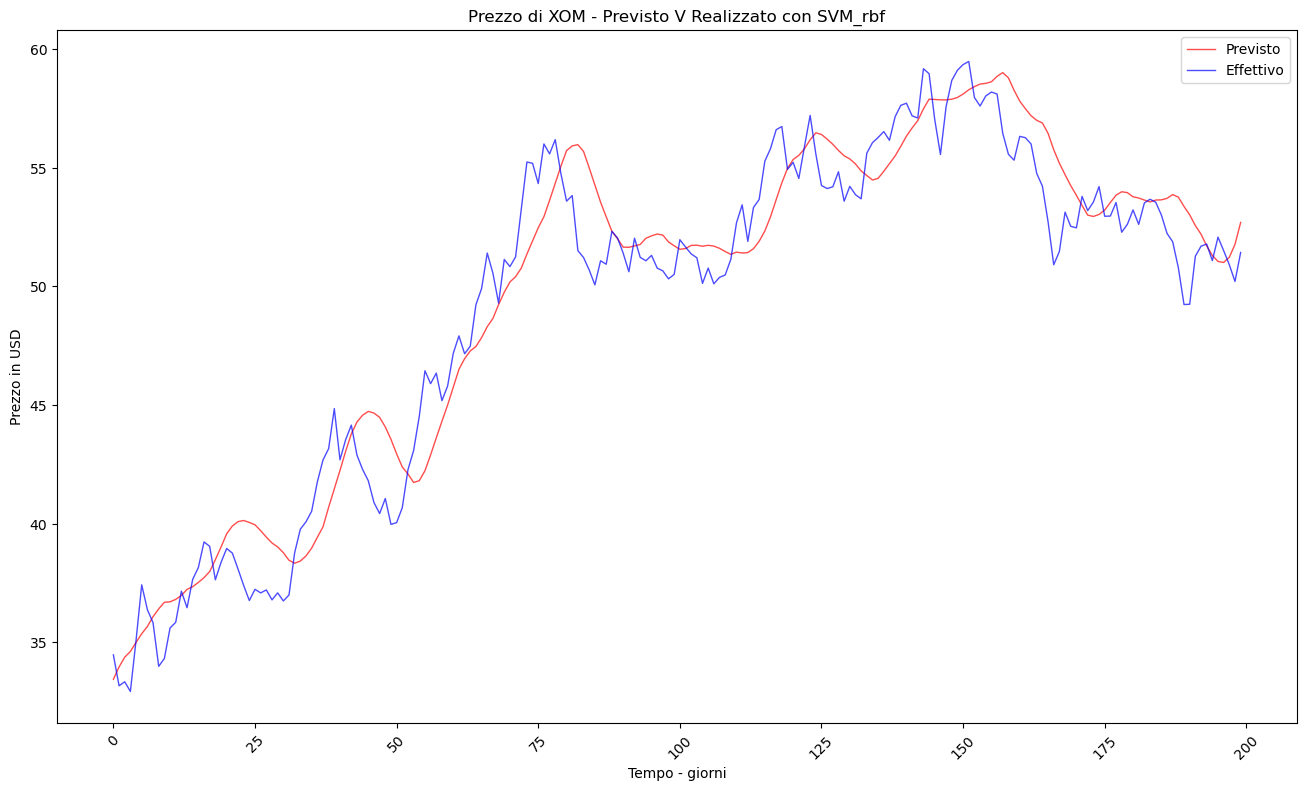

svm_model confidence score is:  0.9259976835732046
Mean Absolute Error: 2.9222983362138497
Mean Squared Error: 16.78548550176736
R2 Score: 0.8978795486261679
0.9259976835732046


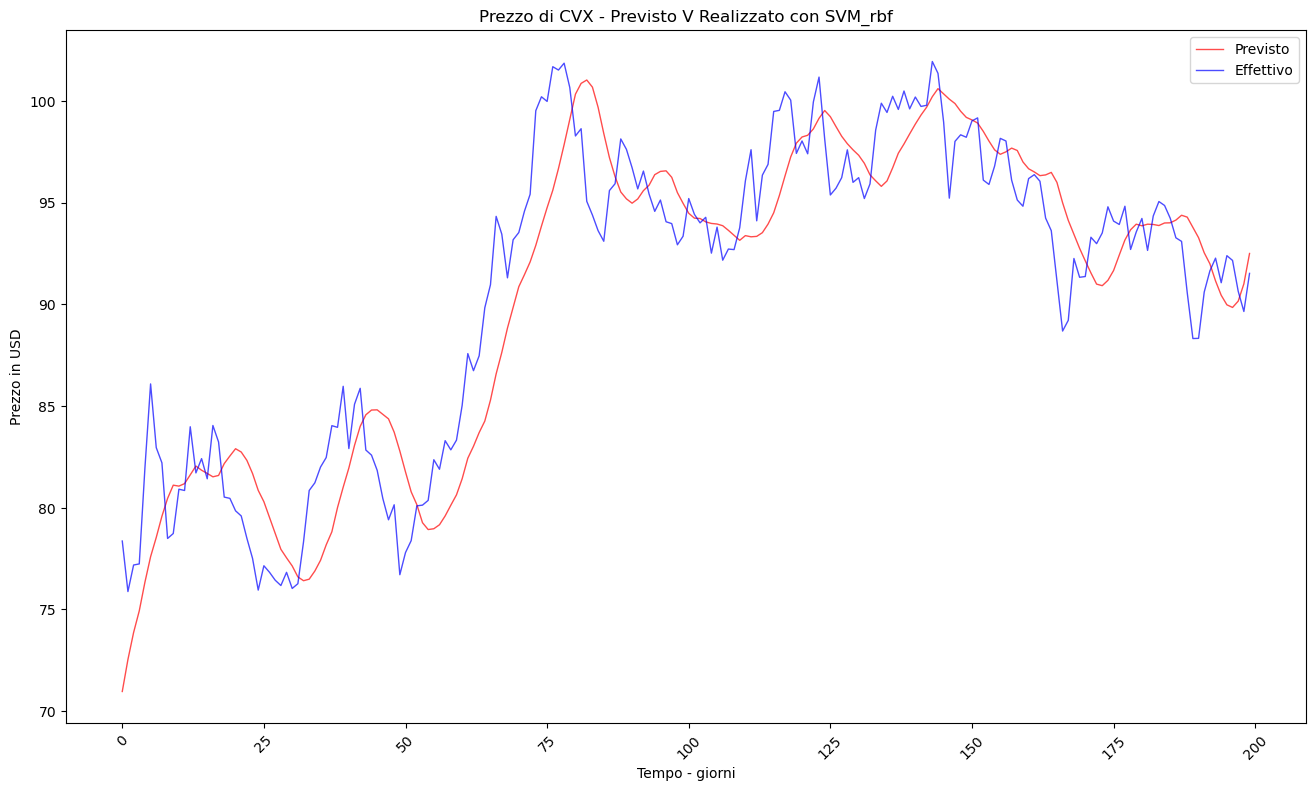

svm_model confidence score is:  0.9091767175454606
Mean Absolute Error: 3.4988870940402665
Mean Squared Error: 23.1888709365587
R2 Score: 0.9541224297941867
0.9091767175454606


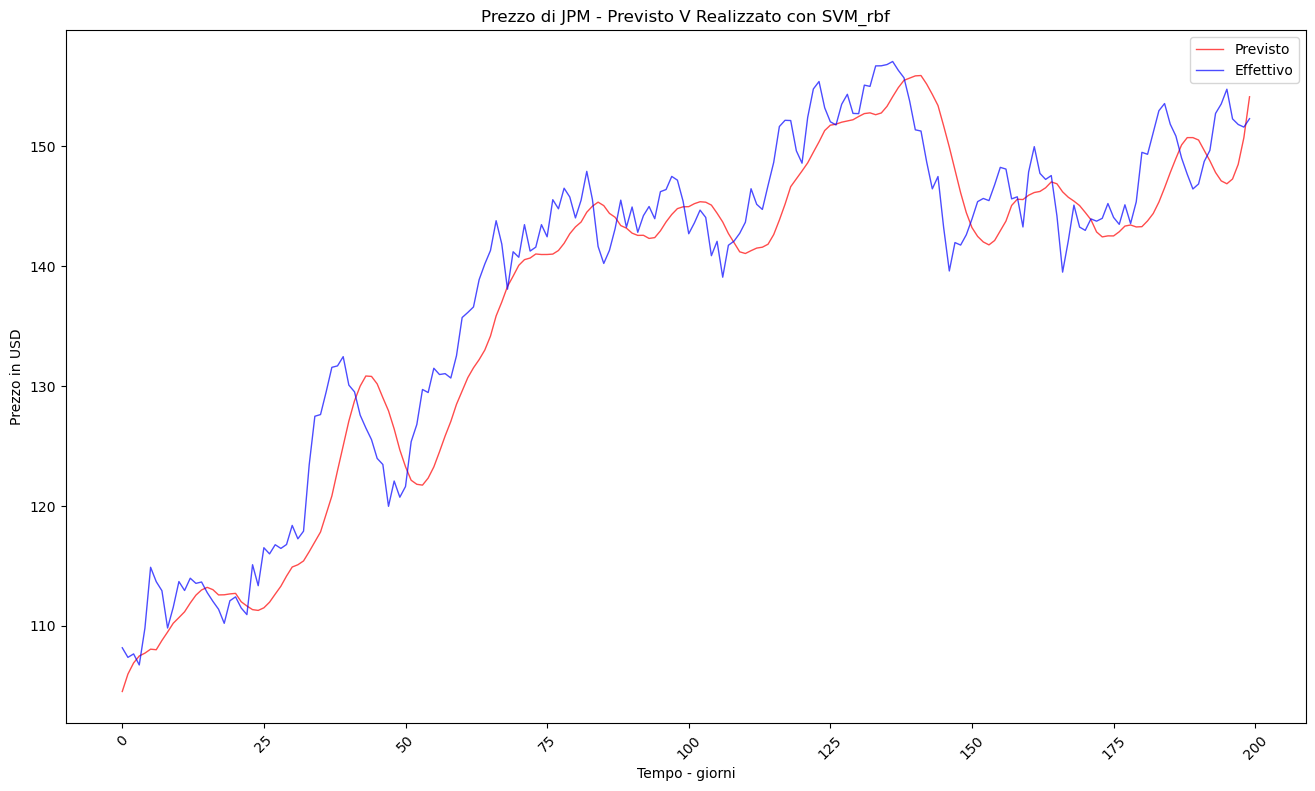

svm_model confidence score is:  0.8922469479155447
Mean Absolute Error: 1.0048371209515345
Mean Squared Error: 1.850196884210581
R2 Score: 0.9479158462213334
0.8922469479155447


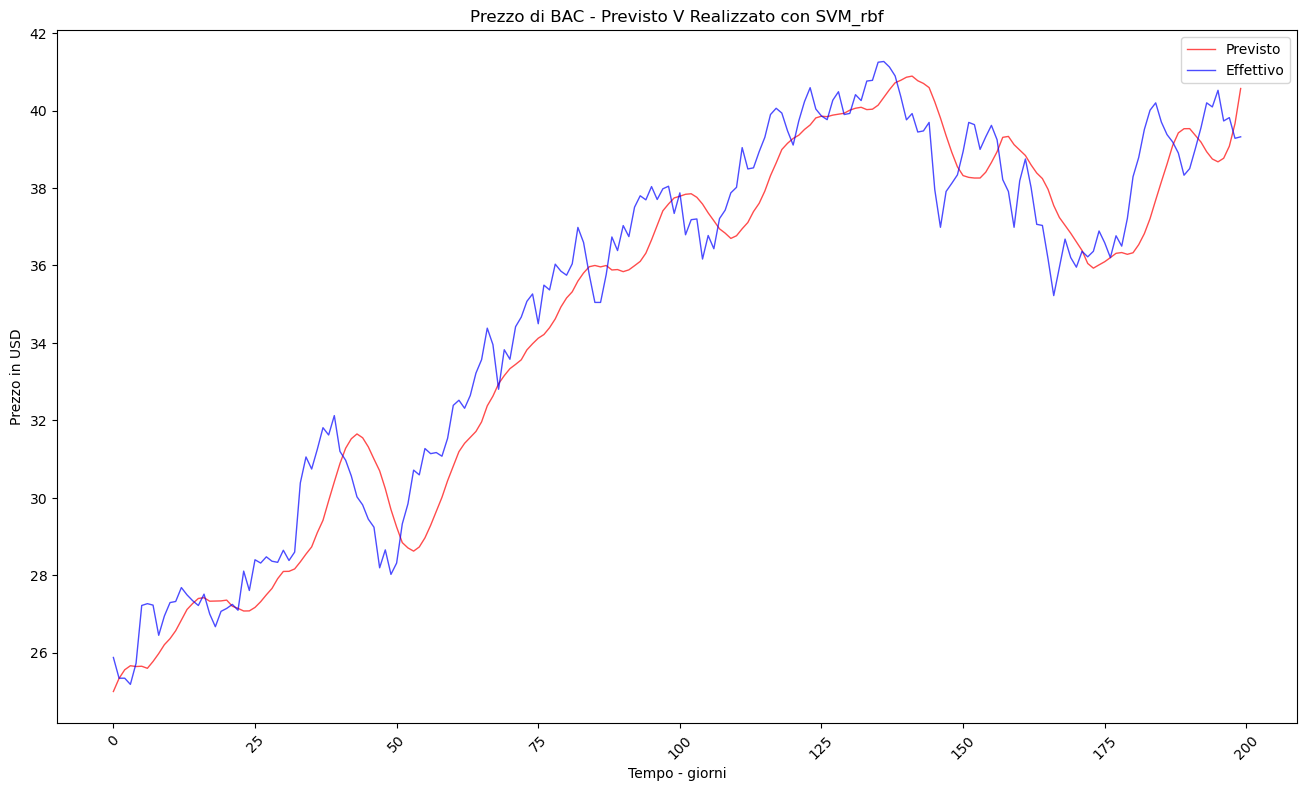

In [39]:
# analisi e grafico per ogni titolo del dataset
start_date_to_pred = '2022-6-30'
end_date_to_pred = '2023-4-30'
tickers_to_pred = ["AAPL", "MSFT", "XOM", "CVX", "JPM", "BAC"]
data_to_pred = yf.download(tickers_to_pred, start=start_date_to_pred, end=end_date_to_pred)

for df in adj_close_tickers:

    X = np.array(df.iloc[:, 0])
    X = X[:df.shape[0] - future_days]
    X = np.reshape(X, (-1, 1))
    
    y = np.array(df.iloc[:, 1])
    y = y[:-future_days]    

    # uso 80 mesi per il training set
    X_train = X[:1600]
    y_train = y[:1600]

    # uso 30 mesi per il validation set
    X_val = X[1600:2200]
    y_val = y[1600:2200]

    # uso 10 mesi per il test set
    X_test = X[2200:]
    y_test = y[2200:]

    # standardizzazione dei dati
    scaler = StandardScaler()
    # fit scaler su training set
    scaler.fit(X_train)
    # trasforma il training set
    X_train = scaler.transform(X_train)
    # trasforma il validation set
    X_val = scaler.transform(X_val)
    # trasforma il test set
    X_test = scaler.transform(X_test)

    svm_model = SVR(kernel='rbf', C = 1e3, gamma = 0.0001)
    svm_model.fit(X_train, y_train)

    svm_model_confidence = svm_model.score(X_test, y_test)
    print('svm_model confidence score is: ', svm_model_confidence)

    svm_prediction = svm_model.predict(X_test)
    svm_prediction_smooth = savgol_filter(svm_prediction, 15, 3)

    svm_prediction_val = svm_model.predict(X_val)
    svm_prediction_val_smooth = savgol_filter(svm_prediction_val, 15, 3)

    mae = mean_absolute_error(y_val, svm_prediction_val)
    mse = mean_squared_error(y_val, svm_prediction_val)
    r2 = r2_score(y_val, svm_prediction_val)

    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("R2 Score:", r2)
    print(svm_model.score(X_test, y_test))

    plt.figure(figsize=(16,9))
    plt.plot(svm_prediction_val_smooth[400:], label = 'Previsto', linewidth = '1', color ='r', alpha = .7)
    plt.plot(y_val[400:], label = 'Effettivo', linewidth = '1', color ='b', alpha = .7)
    plt.title('Prezzo di ' f"{df.columns[0]}" ' - Previsto V Realizzato con SVM_rbf')
    plt.ylabel('Prezzo in USD')
    plt.xlabel('Tempo - giorni')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.show()

#### Strategie di trading e backtesting

In [40]:
# stile dei grafici
style.use('ggplot')

In [41]:
# per ogni ticker creo un df
start_date = '2012-11-30'
end_date = '2022-11-30'
tickers = ["AAPL", "MSFT", "XOM", "CVX", "JPM", "BAC"]
dfs = {}
for ticker in tickers:
    df_name = "df_" + ticker
    ticker_data = yf.download(ticker, start=start_date, end=end_date)
    dfs[df_name] = ticker_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [42]:
for ticker in tickers:
    dfs["df_" + ticker] = dfs["df_" + ticker].drop(columns = ['High', 'Low', 'Open', 'Close'])

In [43]:
# creazione delle due serie mobili
for ticker in tickers:
    dfs["df_" + ticker]['SMA20'] = dfs["df_" + ticker]['Adj Close'].rolling(20).mean()
    dfs["df_" + ticker]['SMA120'] = dfs["df_" + ticker]['Adj Close'].rolling(120).mean()

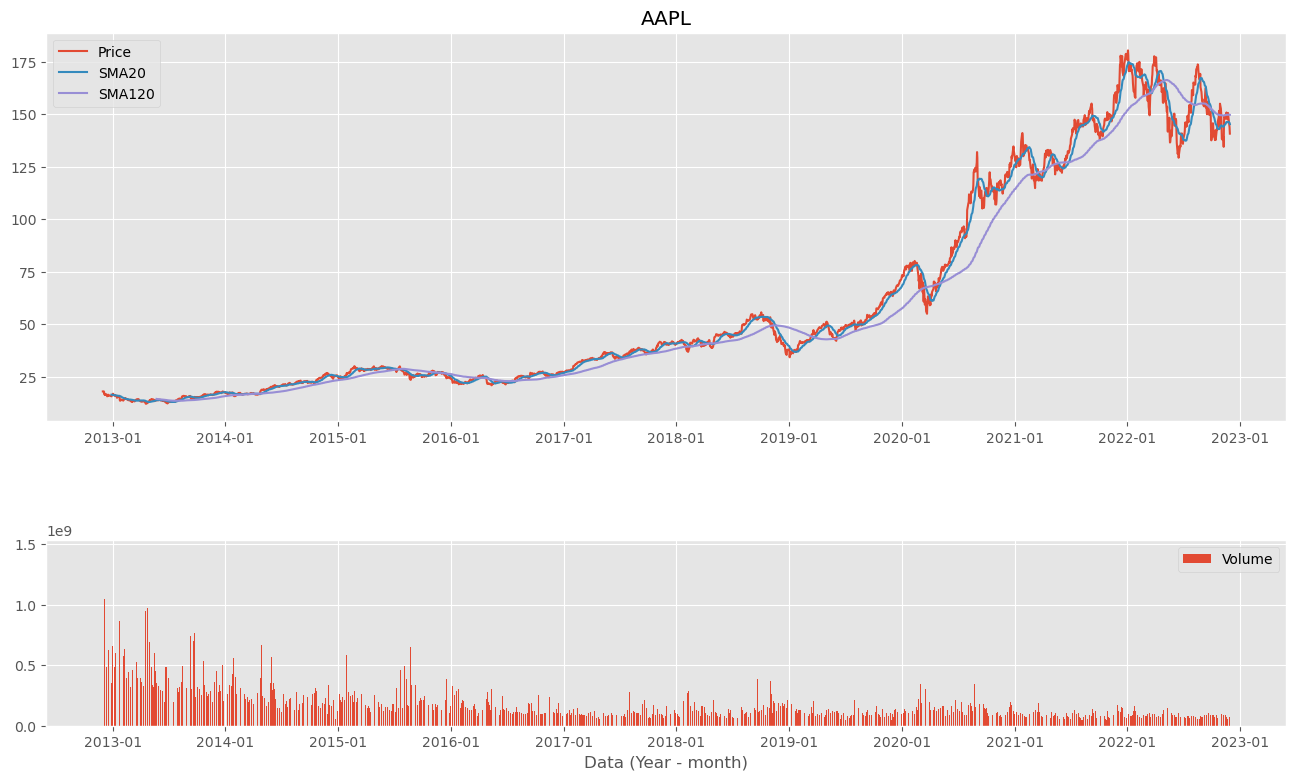

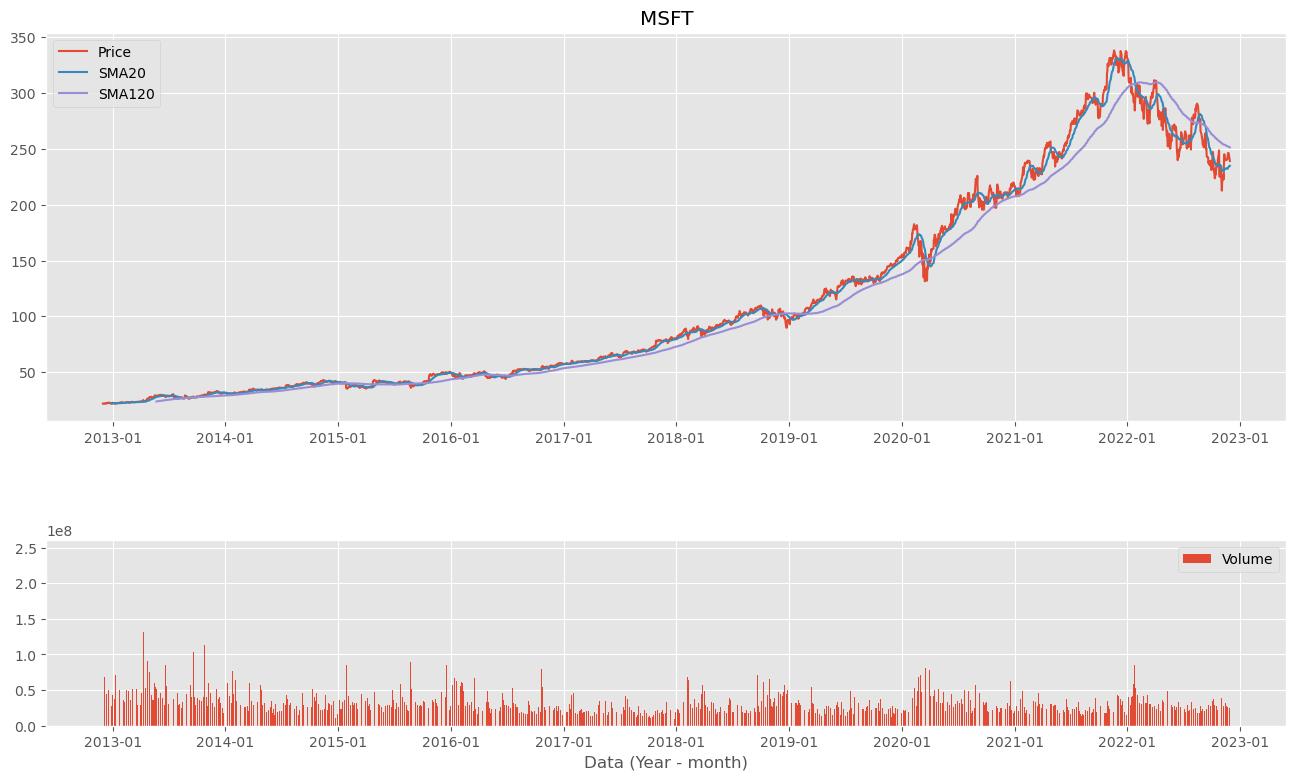

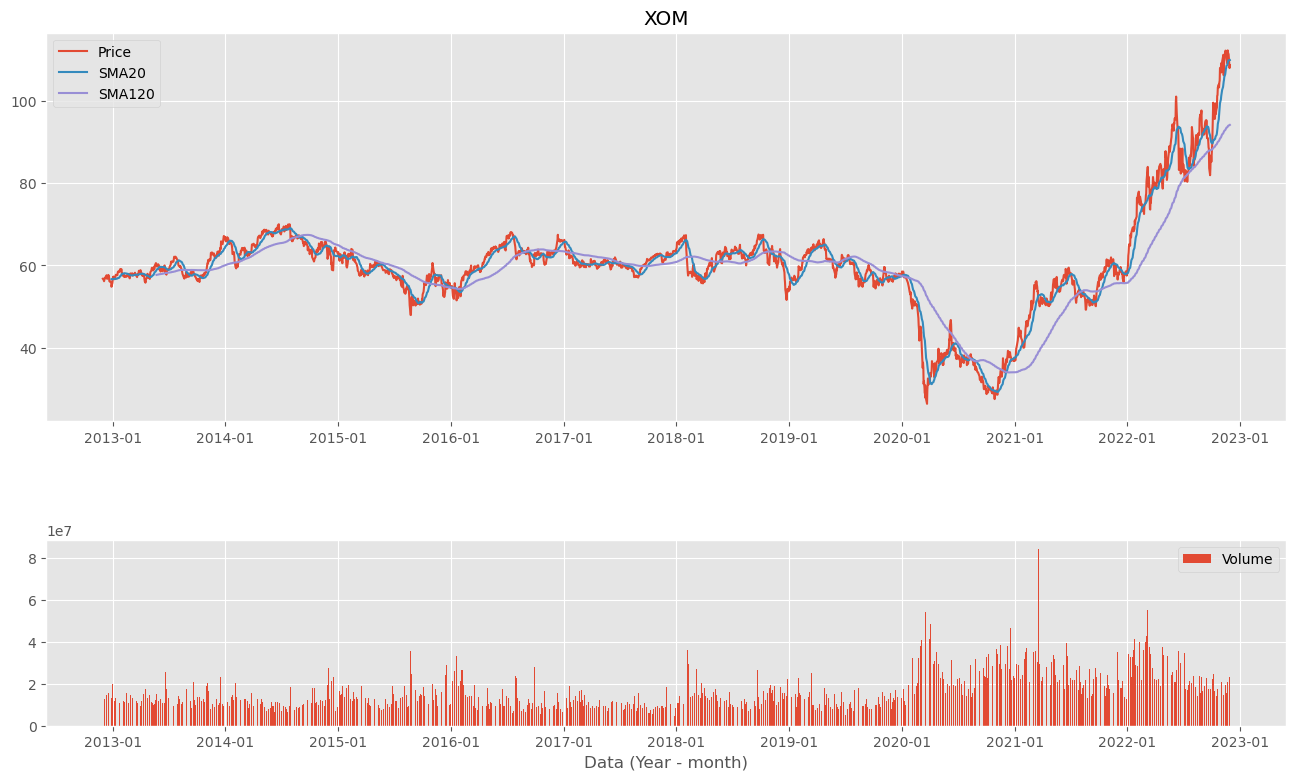

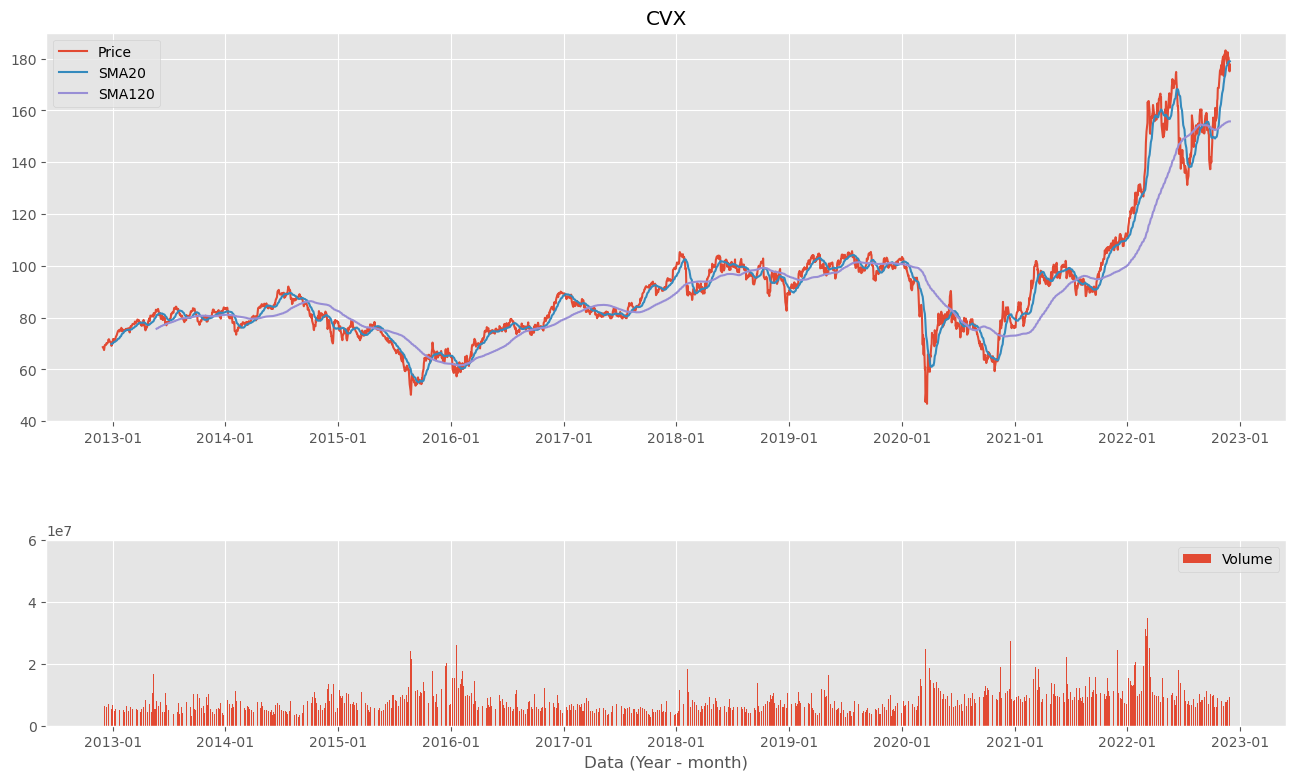

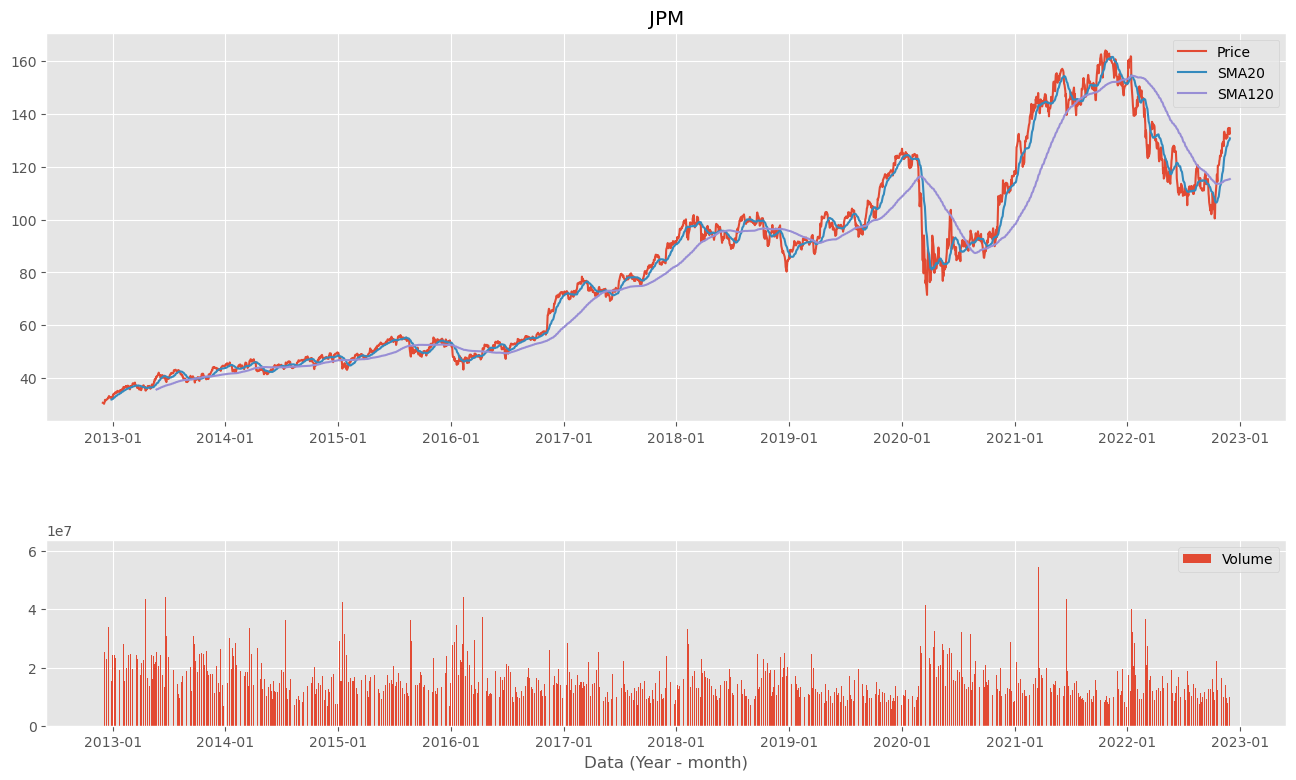

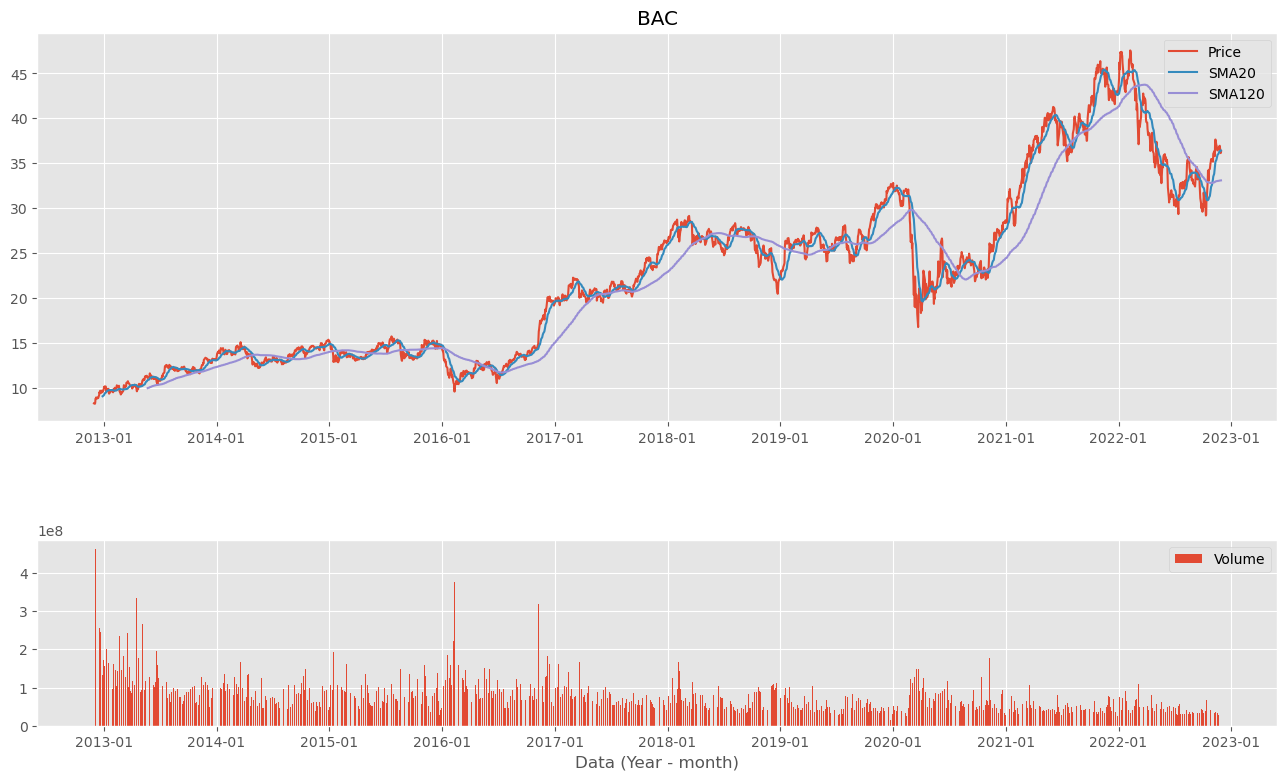

In [44]:
for ticker in tickers:
    df_name = "df_" + ticker
    df = dfs[df_name]

    plt.figure(figsize=(16,9))
    ax1 = plt.subplot2grid((7,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
    ax2 = plt.subplot2grid((7,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
    ax1.plot(df['Adj Close'], label = 'Price')
    ax1.plot(df['SMA20'], label = 'SMA20')
    ax1.plot(df['SMA120'], label = 'SMA120')

    ax2.bar(df.index, df['Volume'], label = 'Volume')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax2.set_xlabel('Data (Year - month)')
    ax1.legend()
    ax2.legend()

In [45]:
smas = {}
# implementazione della strategia e rendimenti
for ticker in tickers:
    df_name = "df_" + ticker
    data = dfs[df_name]

    data['Price_yesterday'] = data['Adj Close'].shift(1)
    data['Change'] = data['Adj Close'] / data['Price_yesterday']
    data['Invested_SMA'] = [1 if data.loc[i, 'SMA20'] > data.loc[i, 'SMA120'] 
                            else 0 for i in data.index]

    sma = "sma_" + ticker
    smas[sma] = data[data['Invested_SMA'] == 1]

In [46]:
for ticker in tickers:
    smas["sma_" + ticker]['Return'] = np.cumprod(smas["sma_" + ticker]['Change'])

C:\cygwin64\tmp\ipykernel_12032\3977734250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smas["sma_" + ticker]['Return'] = np.cumprod(smas["sma_" + ticker]['Change'])
C:\cygwin64\tmp\ipykernel_12032\3977734250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smas["sma_" + ticker]['Return'] = np.cumprod(smas["sma_" + ticker]['Change'])
C:\cygwin64\tmp\ipykernel_12032\3977734250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [47]:
for ticker in tickers:
    smas["sma_" + ticker]['rtn'] = smas["sma_" + ticker]['Return'].pct_change()
    smas["sma_" + ticker]['rtn'].std()*np.sqrt(252)
    smas["sma_" + ticker]['rtn'].mean()*252 / (smas["sma_" + ticker]['rtn'].std()*np.sqrt(252))

C:\cygwin64\tmp\ipykernel_12032\2790321987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smas["sma_" + ticker]['rtn'] = smas["sma_" + ticker]['Return'].pct_change()
C:\cygwin64\tmp\ipykernel_12032\2790321987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smas["sma_" + ticker]['rtn'] = smas["sma_" + ticker]['Return'].pct_change()
C:\cygwin64\tmp\ipykernel_12032\2790321987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [48]:
smas["sma_AAPL"]

Adj Close     Volume       SMA20      SMA120  Price_yesterday  \
Date                                                                         
2013-08-02   14.341992  274783600   13.479922   13.446112        14.160294   
2013-08-05   14.556257  318855600   13.564261   13.447307        14.341992   
2013-08-06   14.426028  334857600   13.630772   13.447646        14.556257   
2013-08-07   14.417651  298858000   13.699375   13.448023        14.426028   
2013-08-08   14.388937  255777200   13.756372   13.449811        14.417651   
...                ...        ...         ...         ...              ...   
2022-09-23  149.744797   96029900  155.346161  153.491719       152.044266   
2022-09-26  150.083252   93339400  154.706588  153.266408       149.744797   
2022-09-27  151.068726   84442700  154.227779  153.077267       150.083252   
2022-09-28  149.157486  146691400  153.776344  152.898918       151.068726   
2022-09-29  141.830994  128138200  153.042700  152.656950       149.157486   

              Change  Invested_SMA    Return       rtn  
Date                                                    
2013-08-02  1.012832             1  1.012832       NaN  
2013-08-05  1.014940             1  1.027963  0.014940  
2013-08-06  0.991053             1  1.018766 -0.008947  
2013-08-07  0.999419             1  1.018175 -0.000581  
2013-08-08  0.998008             1  1.016147 -0.001992  
...              ...           ...       ...       ...  
2022-09-23  0.984876             1  5.653121 -0.015124  
2022-09-26  1.002260             1  5.665899  0.002260  
2022-09-27  1.006566             1  5.703102  0.006566  
2022-09-28  0.987349             1  5.630949 -0.012651  
2022-09-29  0.950881             1  5.354362 -0.049119  

[1823 rows x 9 columns]

In [49]:
# rendimento del "Buy and Hold"
for ticker in tickers:
    df_name = "df_" + ticker
    data = dfs[df_name]
    data['Buy_and_hold'] = np.cumprod(data['Change'])
    data['rtn'] = data['Buy_and_hold'].pct_change()
    data['rtn'].std()

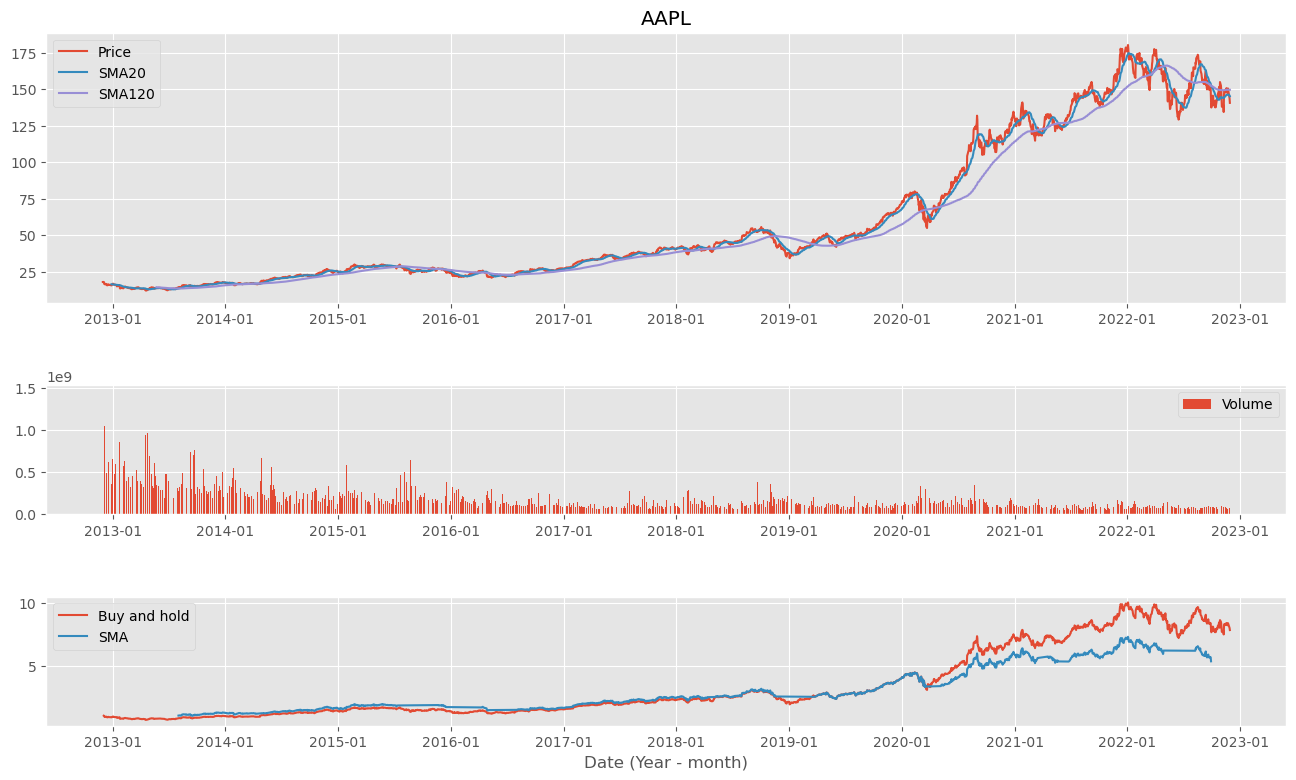

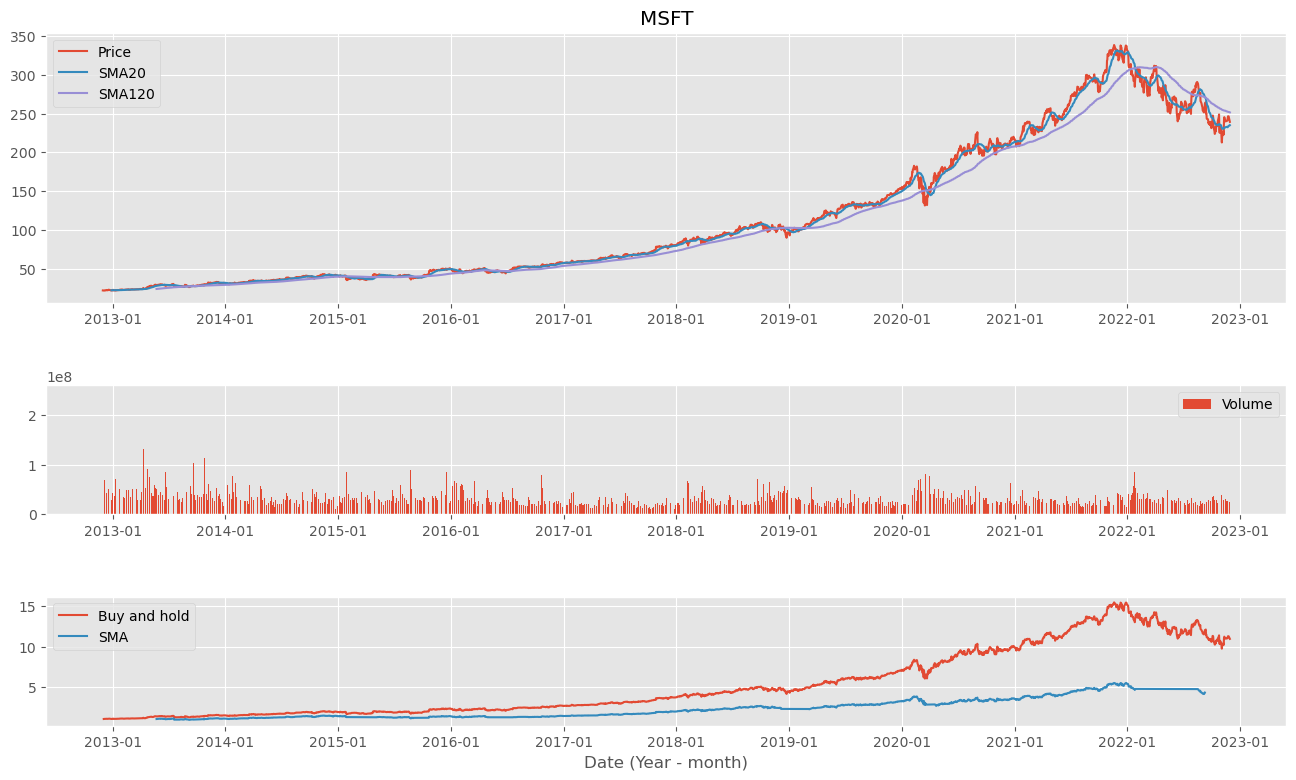

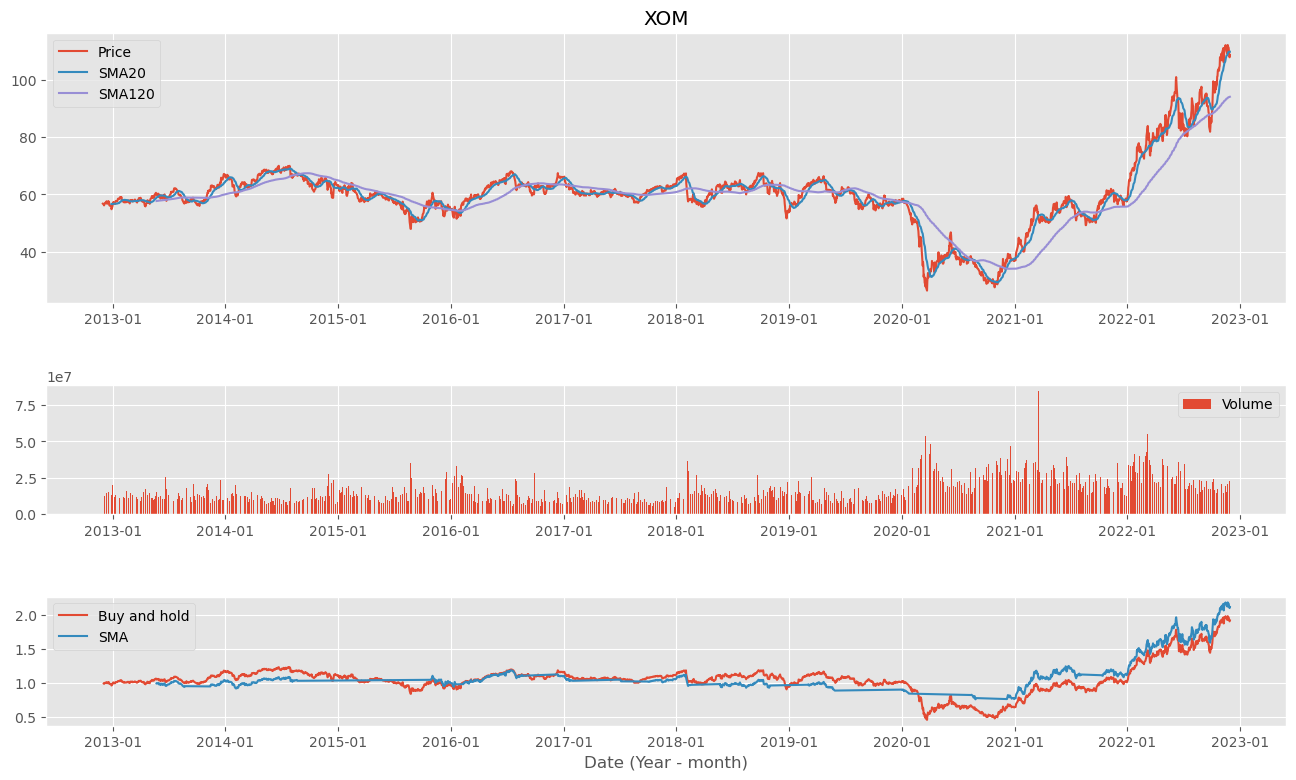

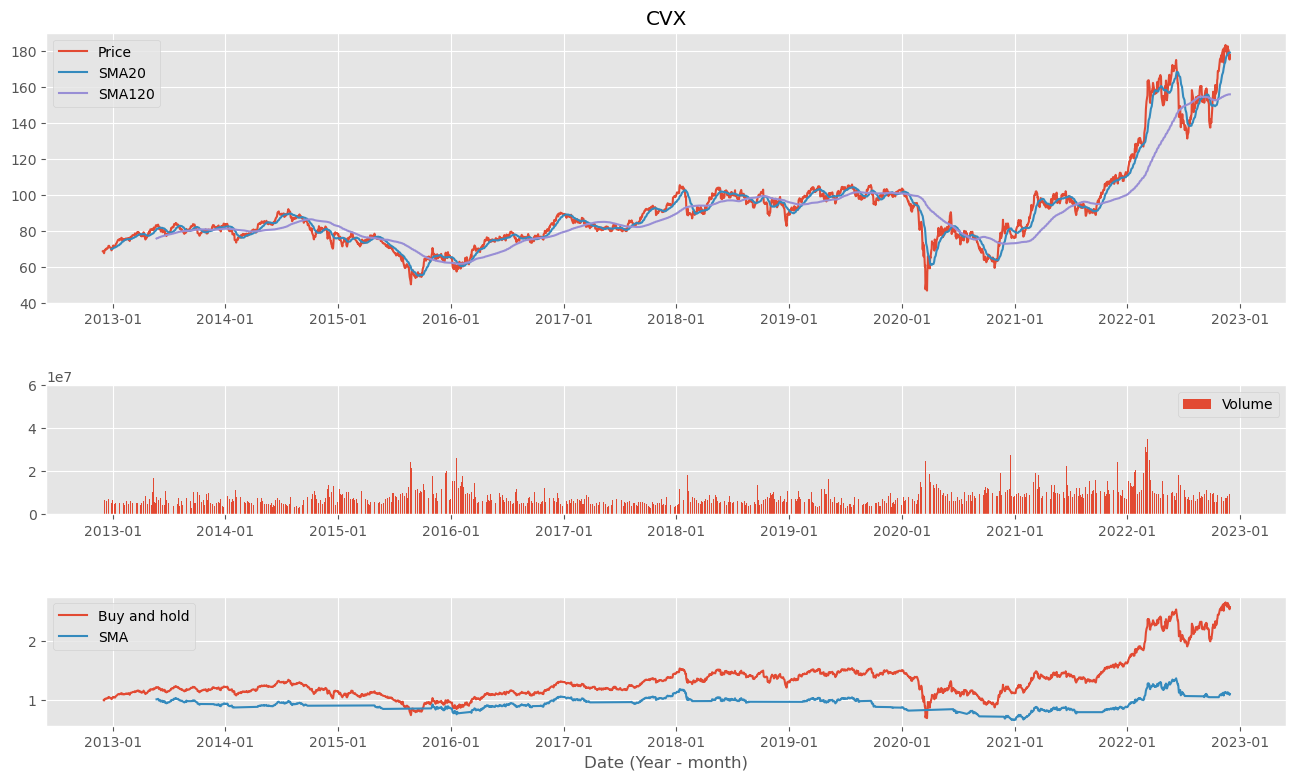

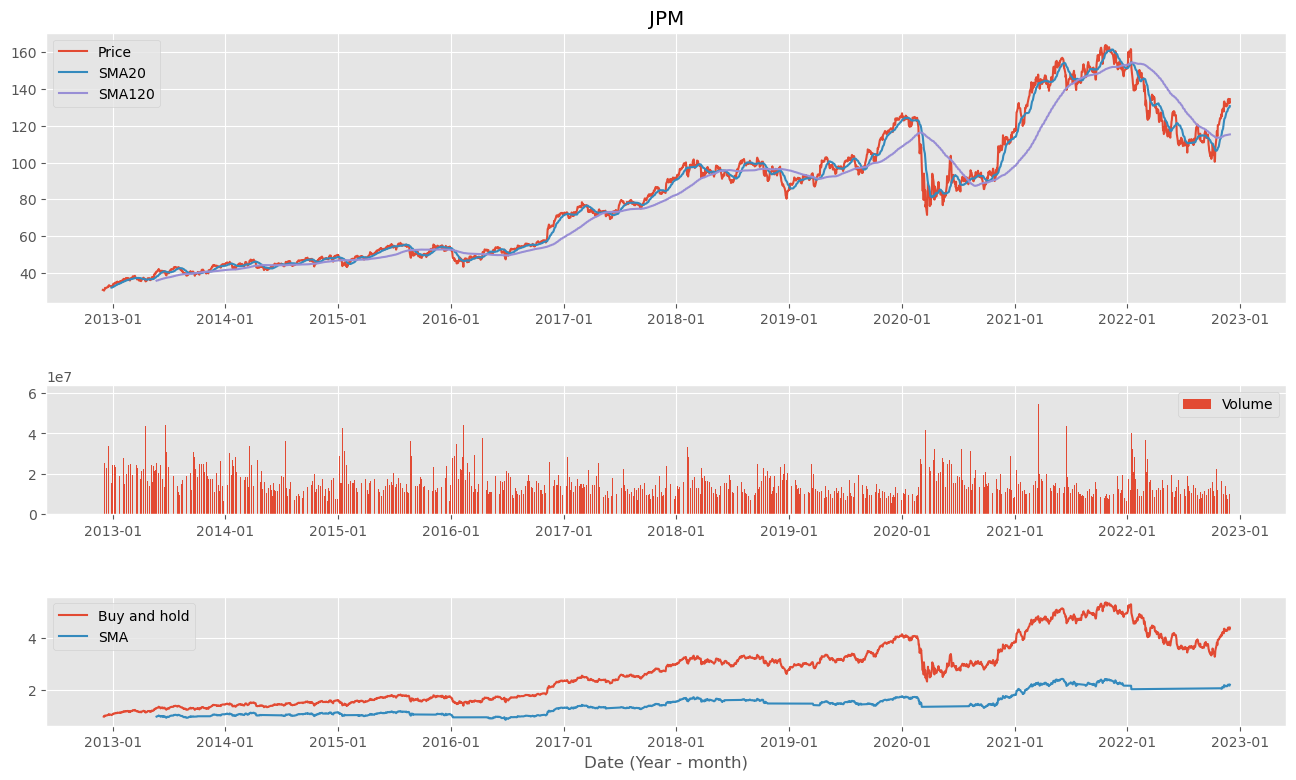

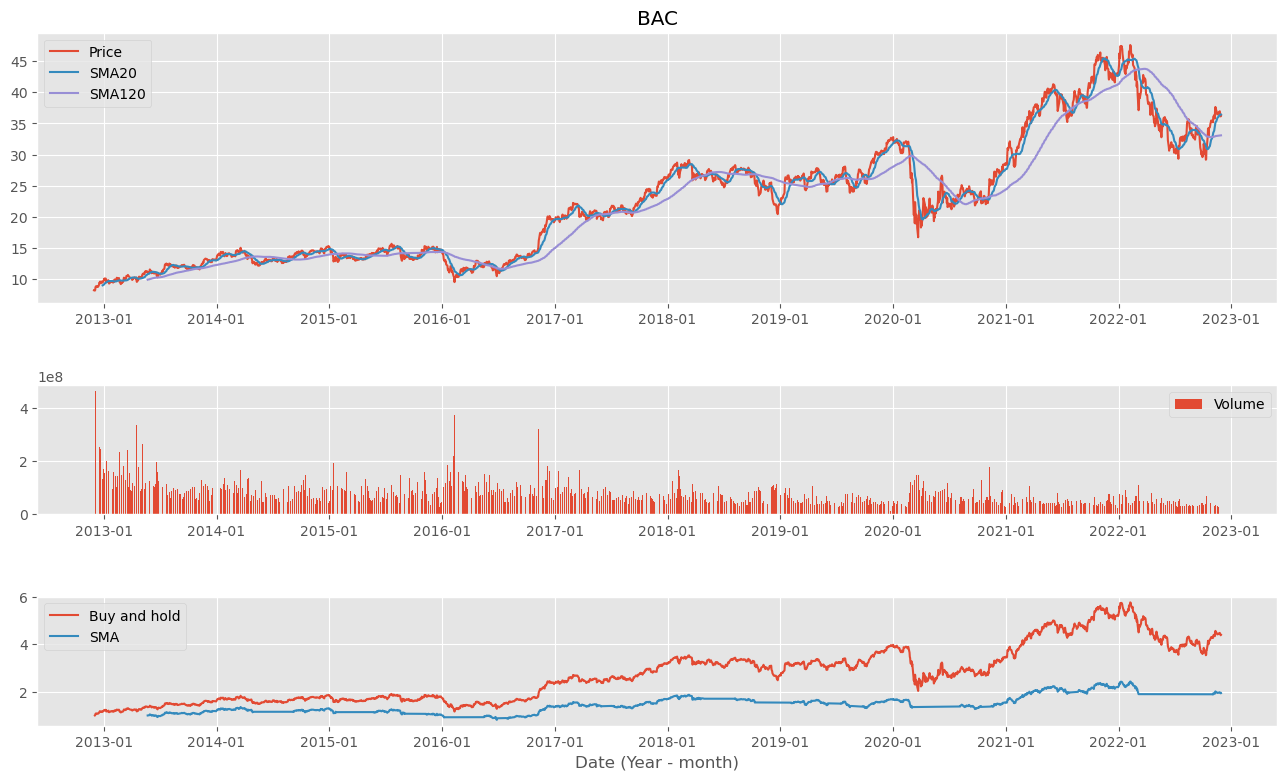

In [50]:
# confronto tra i rendimenti
for ticker in tickers:
    df_data = dfs["df_" + ticker]
    sma_data = smas["sma_" + ticker]

    plt.figure(figsize=(16,9))
    ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1, title = ticker)
    ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 2, colspan = 1, sharex = ax1)
    ax3 = plt.subplot2grid((10,1), (8,0), rowspan = 2, colspan = 1, sharex = ax1)
    ax1.plot(df_data['Adj Close'], label = 'Price')
    ax1.plot(df_data['SMA20'], label = 'SMA20')
    ax1.plot(df_data['SMA120'], label = 'SMA120')

    ax2.bar(df_data.index, df_data['Volume'], label = 'Volume')
    ax3.plot(df_data['Buy_and_hold'], label = 'Buy and hold')
    ax3.plot(sma_data['Return'], label = 'SMA')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax3.set_xlabel('Date (Year - month)')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()


#### CAPM

In [51]:
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\cygwin64\tmp\ipykernel_12032\1743432799.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [52]:
# download dataframs con market benchmark e risk free
start_date = '2012-11-30'
end_date = '2022-11-30'
market_benchmark = '^GSPC'
risk_free = '^IRX'
tickers = ["AAPL", "MSFT", "XOM", "CVX", "JPM", "BAC"]
data_capm = {}

for ticker in tickers:
    df_name = "capm_" + ticker
    data_capm[df_name] = yf.download([ticker, market_benchmark, risk_free], start=start_date, end=end_date)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


In [53]:
# calcolo beta vs market benchmark
assets_beta = {}
for ticker in tickers:
    beta_name = 'beta_' + ticker
    X = data_capm['capm_' + ticker]['Adj Close'].rename(columns={ticker:'asset', market_benchmark:'market', risk_free: 'risk_free'})
    X = X.resample('M').mean()

    # calcolo del market risk free rate
    X['mrf'] = (1 + X['risk_free']/100)**(30/360) - 1

    # calcolo dell'asset risk premium
    X['asset_nmr'] = X['asset'].pct_change() - X['mrf']

    # calcolo del market risk premium
    X['market_nmr'] = X['market'].pct_change() - X['mrf']

    X.dropna(inplace=True)
    X2 = X[['asset_nmr', 'market_nmr']]

    covariance = X2.cov().iloc[0,1]
    benchmark_variance = X2['market_nmr'].var()
    assets_beta[beta_name] = covariance / benchmark_variance

    y = X2.pop('asset_nmr')
    X = sm.add_constant(X2)

    model = sm.OLS(y, X).fit()
    print('\n'+ticker+'\n')
    print(model.summary())



AAPL

                            OLS Regression Results                            
Dep. Variable:              asset_nmr   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     85.34
Date:                Fri, 16 Jun 2023   Prob (F-statistic):           1.27e-15
Time:                        12:49:03   Log-Likelihood:                 185.80
No. Observations:                 120   AIC:                            -367.6
Df Residuals:                     118   BIC:                            -362.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0081      0.005      1.660  

In [54]:
for beta in assets_beta:
    print(beta + ': ', assets_beta[beta])

beta_AAPL:  1.3132905898093212
beta_MSFT:  1.0097398543544116
beta_XOM:  0.869467111438083
beta_CVX:  0.977798079799813
beta_JPM:  1.1094573268881418
beta_BAC:  1.3787239174548698


In [55]:
# modello Fama-French a 3 fattori
factor_df = pd.read_csv('C:/Users/Andrea/Downloads/F-F_Research_Data_Factors_CSV/F-F_Research_Data_Factors.csv', skiprows=3)

In [56]:
# download dataframes per fama-french
start_date = '2012-11-30'
end_date = '2022-11-30'
tickers = ["AAPL", "MSFT", "XOM", "CVX", "JPM", "BAC"]
data_fama_french = {}

for ticker in tickers:
    df_name = "ff_df_" + ticker
    data_fama_french[df_name] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [57]:
# eliminazione dati annuali
stringa = ' Annual Factors: January-December '
indices = factor_df.iloc[:,0] == stringa
start_of_annual = factor_df[indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual]

In [58]:
# rinominazione colonne
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf']
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")

In [59]:
factor_df.head()

data       mkt       smb       hml        rf
0  1926-07      2.96     -2.56     -2.43      0.22
1  1926-08      2.64     -1.17      3.82      0.25
2  1926-09      0.36     -1.40      0.13      0.23
3  1926-10     -3.24     -0.09      0.70      0.32
4  1926-11      2.53     -0.10     -0.51      0.31

In [60]:
factor_df = factor_df.set_index('data')
factor_df = factor_df[start_date:end_date]
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

In [61]:
factor_df.head()

mkt     smb     hml      rf
data                                   
2012-12  0.0118  0.0150  0.0351  0.0001
2013-01  0.0557  0.0033  0.0096  0.0000
2013-02  0.0129 -0.0028  0.0011  0.0000
2013-03  0.0403  0.0081 -0.0019  0.0000
2013-04  0.0155 -0.0236  0.0045  0.0000

In [62]:
factor_df.tail()

mkt     smb     hml      rf
data                                   
2022-07  0.0957  0.0280 -0.0410  0.0008
2022-08 -0.0377  0.0137  0.0030  0.0019
2022-09 -0.0935 -0.0079  0.0006  0.0019
2022-10  0.0783  0.0009  0.0805  0.0023
2022-11  0.0460 -0.0340  0.0138  0.0029

In [63]:
for ticker in tickers:
    df_name = "ff_df_" + ticker

    y = data_fama_french[df_name]['Adj Close'].resample('M').last().pct_change().dropna()
    y.index = y.index.strftime('%Y-%m')
    y.name = 'rtn'

    # uniamo i dati
    ff_data = factor_df.join(y)
    ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

    # salvo i dati per calcolare il beta
    risk_free = ff_data['rf'].mean()
    market_premium = ff_data['mkt'].mean()

    # stimiamo il modello a 3 fattori
    ff_model = smf.ols(formula = 'excess_rtn ~ mkt + smb + hml', data = ff_data).fit()
    print('\n' + ticker + '\n')
    print(ff_model.summary())


AAPL

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     31.62
Date:                Fri, 16 Jun 2023   Prob (F-statistic):           5.17e-15
Time:                        12:49:05   Log-Likelihood:                 166.24
No. Observations:                 120   AIC:                            -324.5
Df Residuals:                     116   BIC:                            -313.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0066      0.006      1.144  

In [64]:
# rendimenti attesi per ogni asset con CAPM
prev_ret = {}
for ticker in tickers:
    rtn_name = "rtn_" + ticker
    expected_return = risk_free + (assets_beta['beta_' + ticker] * market_premium)
    expected_return = expected_return * 12
    prev_ret[rtn_name] = expected_return
    print(ticker + ': ', expected_return)

AAPL:  0.1754223027553768
MSFT:  0.13638264266852088
XOM:  0.11834216520205185
CVX:  0.13227461104305396
JPM:  0.1492073068110839
BAC:  0.1838376830238708


#### Costruzione di un portafoglio

In [65]:
# configurazione plotter
plt.style.use('seaborn')
sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300

C:\cygwin64\tmp\ipykernel_12032\2198907352.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [78]:
# download prezzi e impostazioni per il portafoglio
n_port = 10 ** 5
n_days = 252
start_date = '2012-11-30'
end_date = '2021-11-30'
tickers = ["AAPL", "MSFT", "XOM", "CVX", "JPM", "BAC"]
n_assets = len(tickers)

opt_df = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  6 of 6 completed


In [79]:
returns_df = opt_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * n_days
cov_mat = returns_df.cov() * n_days

In [80]:
# funzione per calcolare rendimento e varianza di un portafoglio
def calcola_rendimento_varianza_portafoglio(pesi, rendimenti_attesi, matrice_covarianza):
    rendimento_portafoglio = np.sum(rendimenti_attesi * pesi)
    varianza_portafoglio = np.dot(pesi.T, np.dot(matrice_covarianza, pesi))
    return rendimento_portafoglio, varianza_portafoglio

In [81]:
# funzione per generare portafogli casuali
def monte_carlo(rendimenti_attesi, matrice_covarianza, num_portafogli):
    num_societa = len(rendimenti_attesi)
    risultati = np.zeros((3, num_portafogli))
    pesi_casuali = []

    for i in range(num_portafogli):
        pesi = np.random.random(num_societa)
        pesi /= np.sum(pesi)
        pesi_casuali.append(pesi)
        rendimento_portafoglio, varianza_portafoglio = calcola_rendimento_varianza_portafoglio(pesi, rendimenti_attesi, matrice_covarianza)
        risultati[0, i] = rendimento_portafoglio
        risultati[1, i] = varianza_portafoglio
        risultati[2, i] = risultati[0, i] / risultati[1, i]  # Rapporto rendimento/varianza

    return risultati, pesi_casuali

In [82]:
num_portafogli = 10000  # Numero di portafogli casuali da generare
risultati, pesi_casuali = monte_carlo(avg_returns, cov_mat, num_portafogli)

In [83]:
indice_migliore = np.argmax(risultati[2])
pesi_migliori = pesi_casuali[indice_migliore]
rendimento_migliore, varianza_migliore = risultati[0, indice_migliore], risultati[1, indice_migliore]

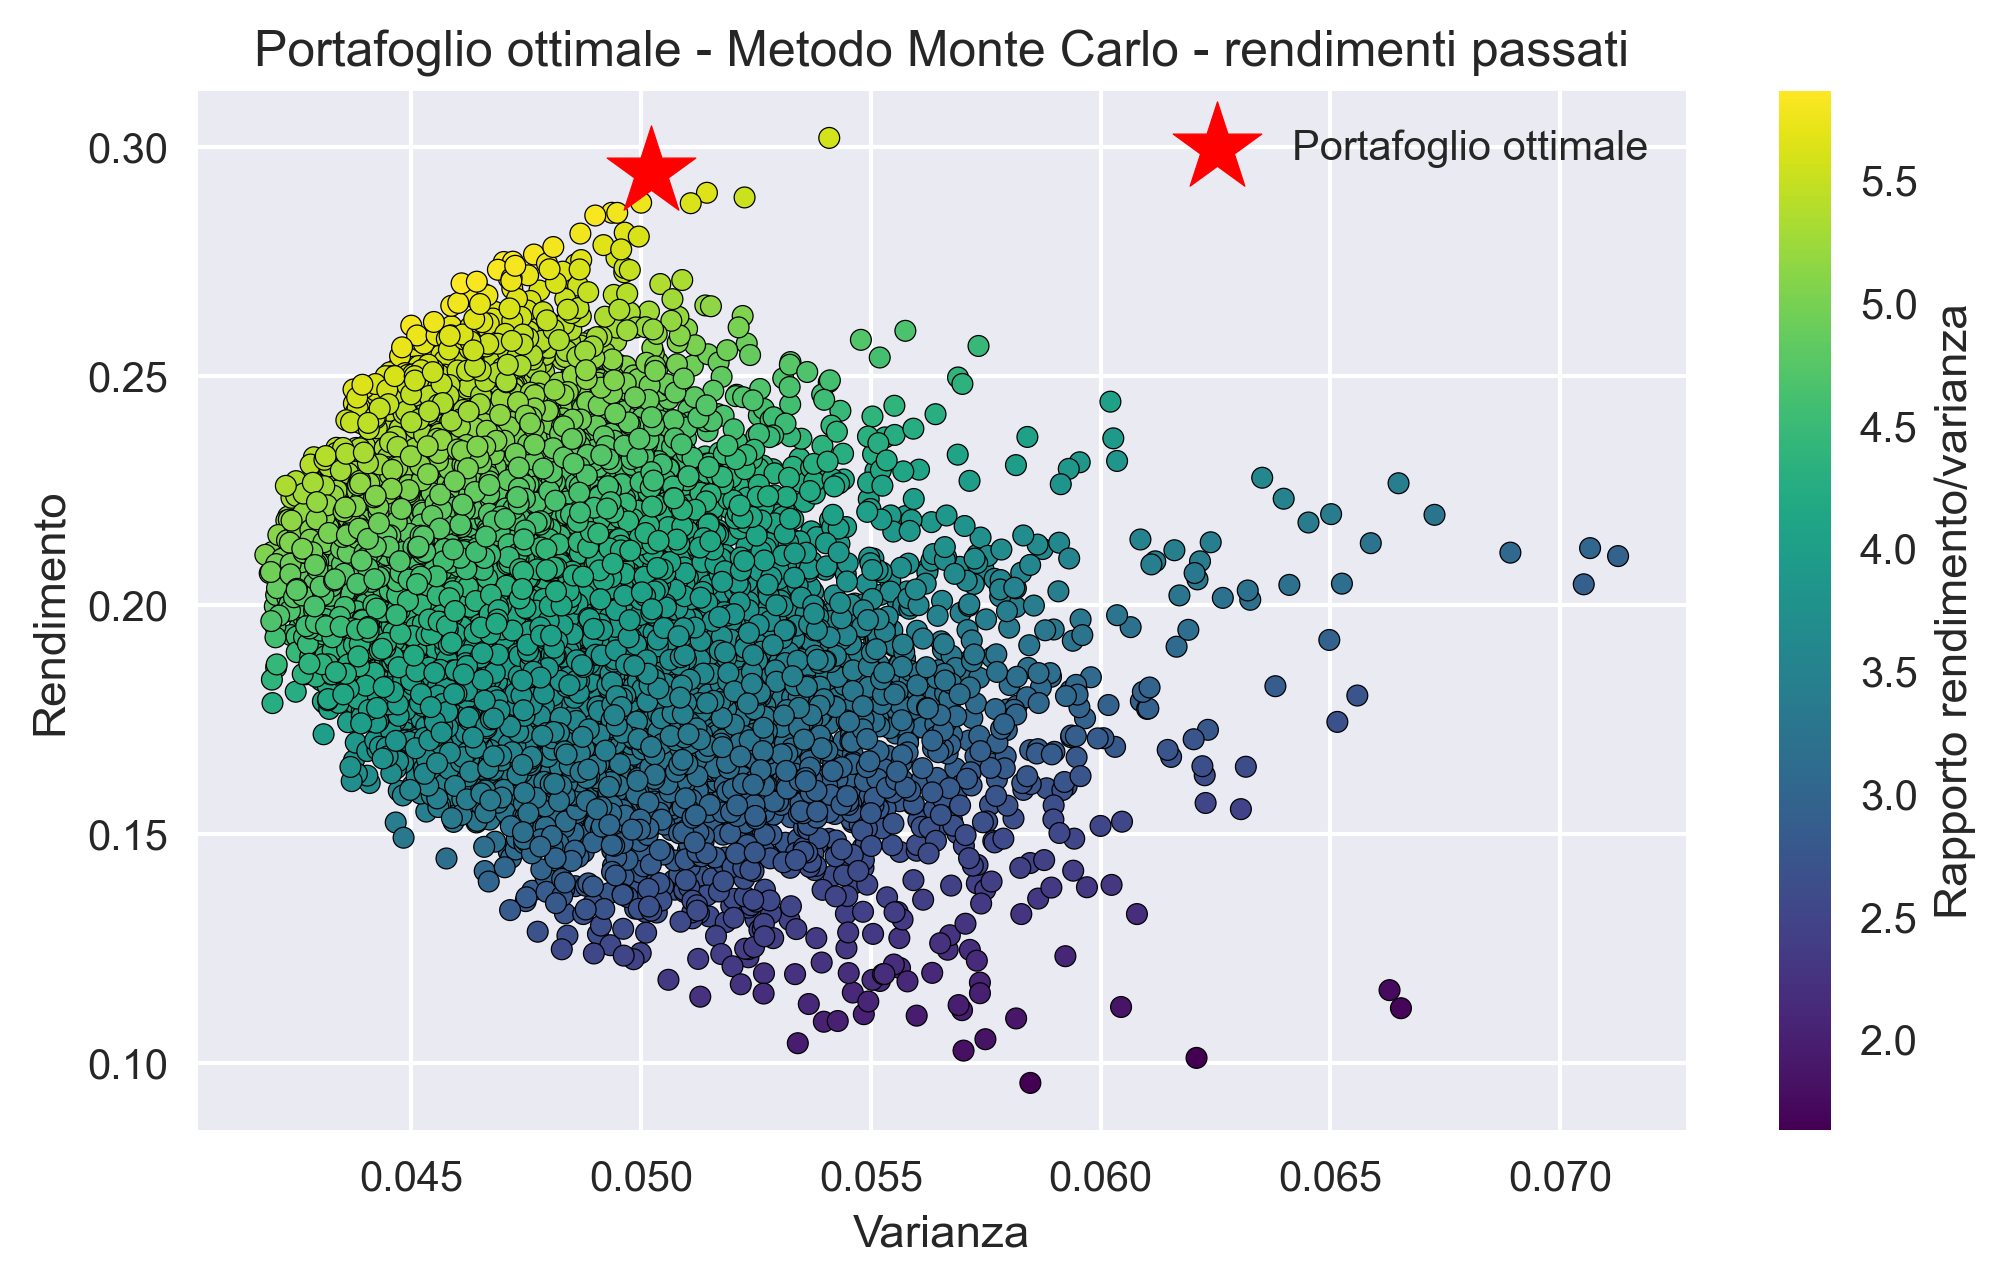

In [84]:
# frontiera efficiente - metodo Monte Carlo - rendimenti passati
plt.scatter(risultati[1, :], risultati[0, :], c=risultati[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Rapporto rendimento/varianza')
plt.scatter(varianza_migliore, rendimento_migliore, marker='*', color='r', s=500, label='Portafoglio ottimale')
plt.xlabel('Varianza')
plt.ylabel('Rendimento')
plt.title('Portafoglio ottimale - Metodo Monte Carlo - rendimenti passati')
plt.legend()
plt.show()

In [85]:
# media rendimenti previsti in prev_ret
rendimenti_attesi = np.array(list(prev_ret.values()))

In [86]:
num_portafogli = 10000  # Numero di portafogli casuali da generare
risultati, pesi_casuali = monte_carlo(rendimenti_attesi, cov_mat, num_portafogli)

In [87]:
indice_migliore = np.argmax(risultati[2])
pesi_migliori = pesi_casuali[indice_migliore]
rendimento_migliore, varianza_migliore = risultati[0, indice_migliore], risultati[1, indice_migliore]

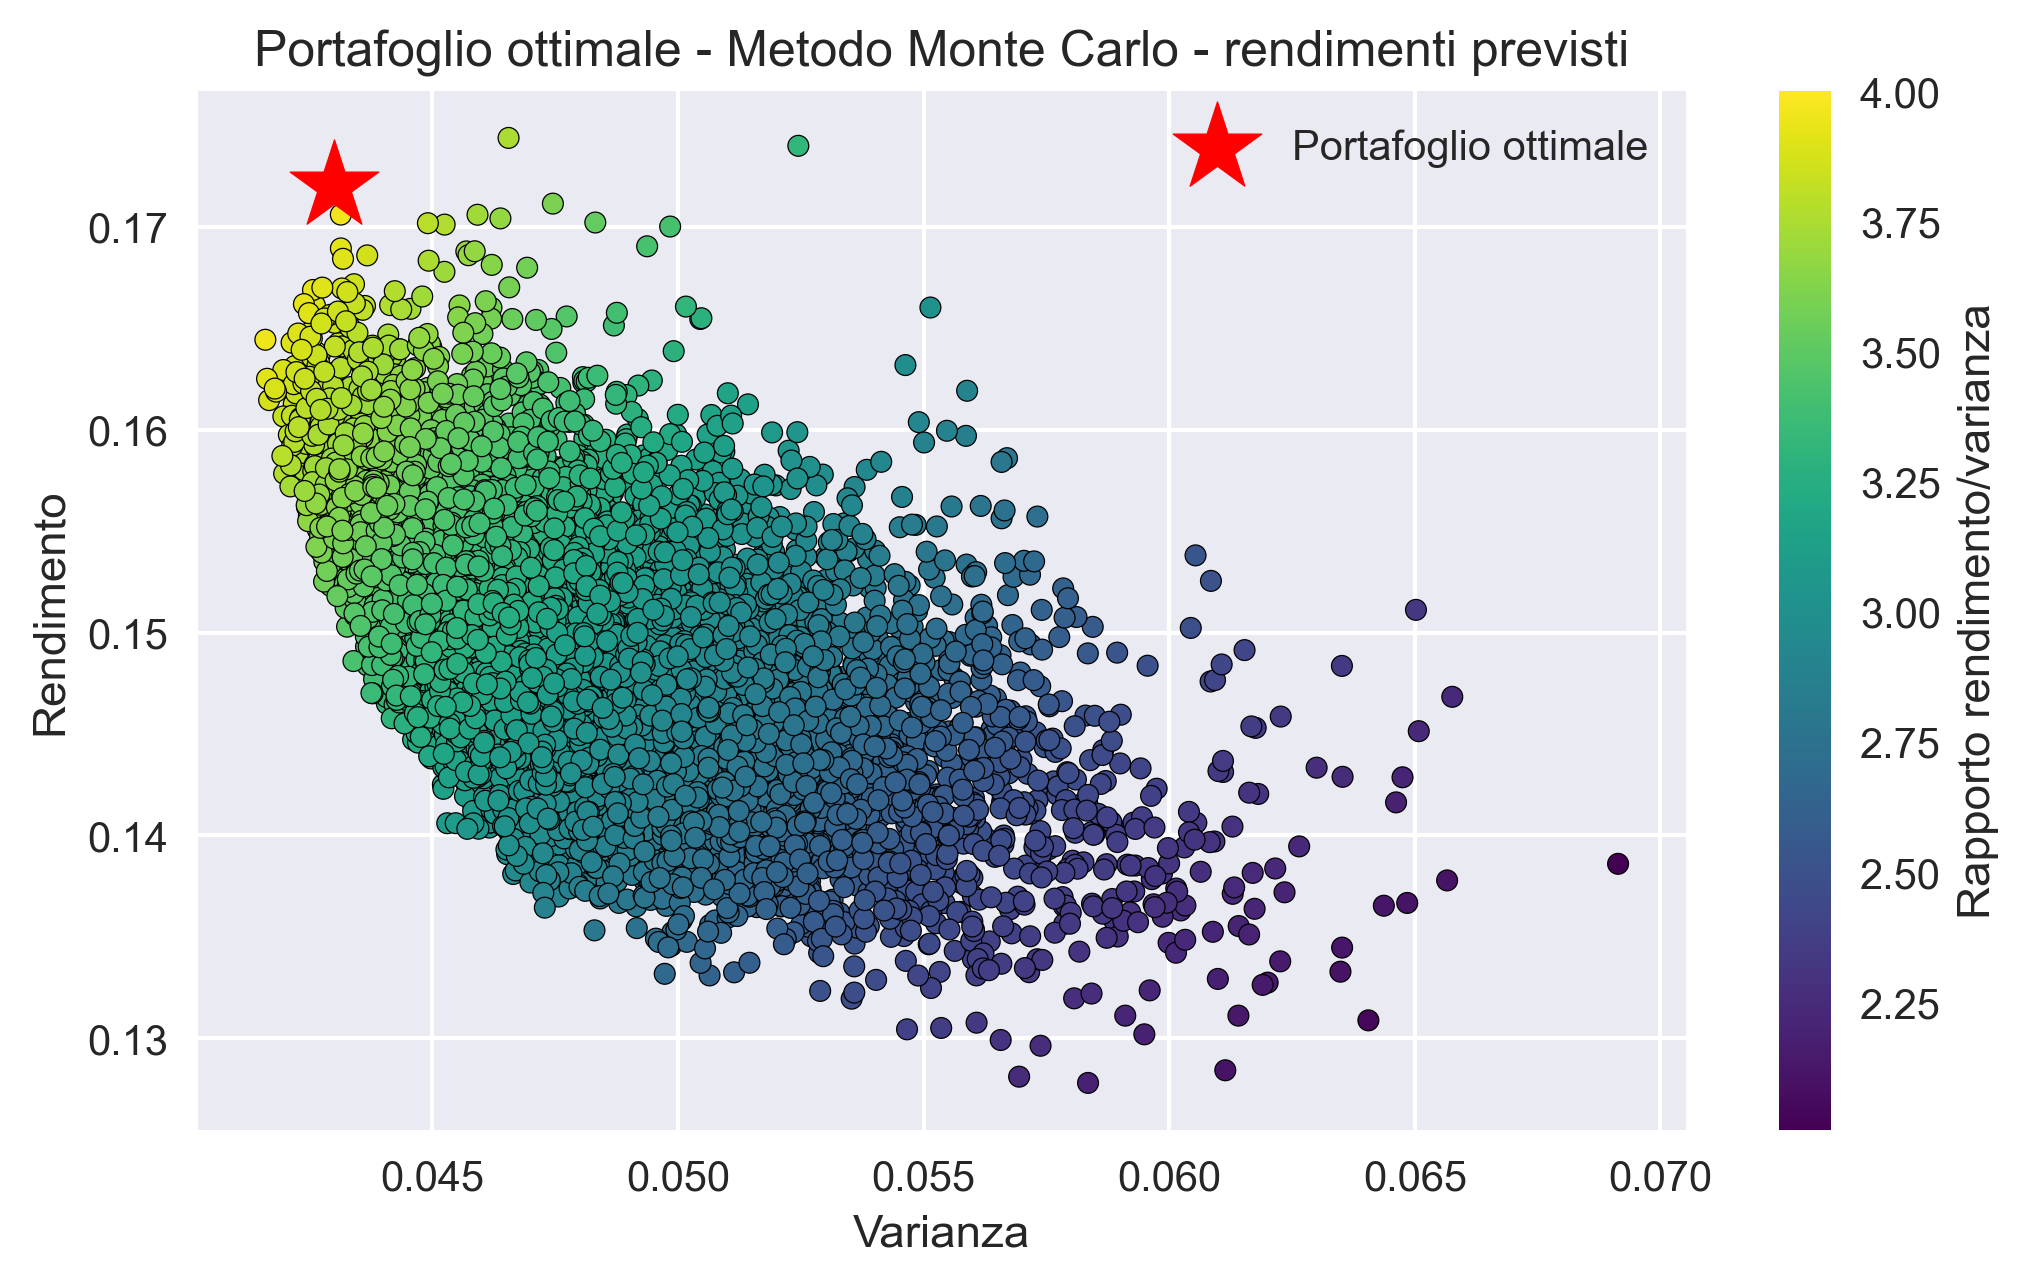

In [88]:
# frontiera efficiente - metodo Monte Carlo - rendimenti previsti
plt.scatter(risultati[1, :], risultati[0, :], c=risultati[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Rapporto rendimento/varianza')
plt.scatter(varianza_migliore, rendimento_migliore, marker='*', color='r', s=500, label='Portafoglio ottimale')
plt.xlabel('Varianza')
plt.ylabel('Rendimento')
plt.title('Portafoglio ottimale - Metodo Monte Carlo - rendimenti previsti')
plt.legend()
plt.show()

In [77]:
# beta del portafoglio rispetto al mercato (rendimento indice SP500 e miglior rendimento atteso portafoglio)
beta = rendimento_migliore / rendimenti_attesi

print("Beta del portafoglio:", beta)

Beta del portafoglio: [0.95618182 1.22988976 1.41737829 1.26808625 1.1241783  0.9124115 ]
